<a href="https://colab.research.google.com/github/AbdulSafiCS/Tax-Filing-Pattern-Classification/blob/master/Tax_Filing_Patterns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
install.packages(c("tidyverse", "dplyr", "cluster", "factoextra", "googlesheets4", "mclust", "dbscan", "clusterCrit", "dendextend", "randomForest", "caret", "PRROC", "ranger"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘rbibutils’, ‘future’, ‘globals’, ‘Deriv’, ‘microbenchmark’, ‘Rdpack’, ‘shape’, ‘future.apply’, ‘progressr’, ‘SQUAREM’, ‘doBy’, ‘SparseM’, ‘MatrixModels’, ‘minqa’, ‘nloptr’, ‘reformulas’, ‘lazyeval’, ‘diagram’, ‘lava’, ‘carData’, ‘Formula’, ‘pbkrtest’, ‘quantreg’, ‘lme4’, ‘crosstalk’, ‘estimability’, ‘mvtnorm’, ‘numDeriv’, ‘corrplot’, ‘prodlim’, ‘car’, ‘DT’, ‘ellipse’, ‘emmeans’, ‘flashClust’, ‘leaps’, ‘multcompView’, ‘scatterplot3d’, ‘ggsci’, ‘cowplot’, ‘ggsignif’, ‘gridExtra’, ‘polynom’, ‘rstatix’, ‘proxy’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘sparsevctrs’, ‘timeDate’, ‘abind’, ‘FactoMineR’, ‘ggpubr’, ‘reshape2’, ‘ggrepel’, ‘viridis’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘RcppEigen’




In [ ]:
library(googlesheets4)
gs4_deauth()

In [ ]:
sheet_url <- "https://docs.google.com/spreadsheets/d/1JEMUdiZ5InSL_1x2OpL6Uen0iszYnlPQ3CwzVWZuwCI/edit?usp=sharingE"
data <- read_sheet(sheet_url)

head(data)

✔ Reading from MATH 445 - Project 2 Data.

✔ Range Sheet1.



ID Filing_Date Employment_Type Filing_Status   Resident_Status Dependents
1 1  2025-03-02  salaried        single          u.s.            0         
2 2  2025-04-17  self-employed   single          u.s.            0         
3 3  2025-08-07  salaried        single          u.s.            0         
4 4  2025-02-11  salaried        single          u.s.            1         
5 5  2025-02-21  salaried        married jointly u.s.            1         
6 6  2025-10-19  salaried        single          u.s.            0         
  Taxpayer_Age <NA> <NA> <NA> <NA>  <NA> Zipcode Income Investment_Income <NA>
1 40           61   33   21   27|27 35   91607   21450  none              none
2 40           61   33   21   27|27 35   90005   12643  none              none
3 40           61   33   21   27|27 35   90255   67618  none              none
4 40           61   33   21   27|27 35   90006   37284  none              none
5 40           61   33   21   27|27 35   90007   49664  none              none
6 40           61   33   21   27|27 35   90019   43313  none              none
  <NA> <NA> <NA> <NA> Amount_owed_or_Refund
1 none none none none -196                 
2 none none none none -1,649               
3 none none none none -1,993               
4 none none none none +2,994               
5 none none none none +645                 
6 none none none none -604

###Data Structure / Summary

In [ ]:
nrow(data)

[1] 200

###Missing Data?

In [ ]:
# Predict Income using other variables
income_model <- lm(Income ~ Taxpayer_Age + Dependents + Employment_Type + Filing_Status, data = df_class)

# Predict missing Income values
missing_income <- is.na(df_class$Income)
df_class$Income[missing_income] <- predict(income_model, newdata = df_class[missing_income, ])

resid_sd <- sd(income_model$residuals, na.rm = TRUE)
df_class$Income[missing_income] <- predict(income_model, newdata = df_class[missing_income, ]) +
                                   rnorm(sum(missing_income), mean = 0, sd = resid_sd)


In [ ]:
nrow(df_class)

[1] 100

In [ ]:
# Count missing values per column
missing_counts <- colSums(is.na(data))
missing_counts

# Create a summary table with counts and percentages
missing_summary <- data.frame(
  Column = names(data),
  Missing_Count = colSums(is.na(data)),
  Missing_Percent = round(colSums(is.na(data)) / nrow(data) * 100, 2)
)

missing_summary

ID           Filing_Date       Employment_Type 
                    0                     0                     0 
        Filing_Status       Resident_Status            Dependents 
                    0                     0                     0 
         Taxpayer_Age               Zipcode                Income 
                    0                    84                   100 
    Investment_Income Amount_owed_or_Refund 
                    0                   100

,Column,Missing_Count,Missing_Percent
,<chr>,<dbl>,<dbl>
ID,ID,0,0
Filing_Date,Filing_Date,0,0
Employment_Type,Employment_Type,0,0
Filing_Status,Filing_Status,0,0
Resident_Status,Resident_Status,0,0
Dependents,Dependents,0,0
Taxpayer_Age,Taxpayer_Age,0,0
Zipcode,Zipcode,84,42
Income,Income,100,50


###regression imputation

In [ ]:
# Build a regression model to predict Income using other variables
income_model <- lm(Income ~ Taxpayer_Age + Dependents + Employment_Type + Filing_Status, data = df_class)

# Get residual standard deviation
resid_sd <- sd(income_model$residuals, na.rm = TRUE)

# Find rows where Income is missing
missing_income <- is.na(df_class$Income)

# Predict Income for missing cases and add random noise
df_class$Income[missing_income] <- predict(income_model, newdata = df_class[missing_income, ]) +
                                   rnorm(sum(missing_income), mean = 0, sd = resid_sd)


In [ ]:
age_model <- lm(Taxpayer_Age ~ Income + Dependents + Employment_Type + Filing_Status, data = df_class)
age_sd <- sd(age_model$residuals, na.rm = TRUE)
missing_age <- is.na(df_class$Taxpayer_Age)

df_class$Taxpayer_Age[missing_age] <- predict(age_model, newdata = df_class[missing_age, ]) +
                                      rnorm(sum(missing_age), mean = 0, sd = age_sd)


In [ ]:
nrow(df_class)

[1] 100

In [ ]:
# Count missing values per column
missing_counts <- colSums(is.na(data))
missing_counts

# Create a summary table with counts and percentages
missing_summary <- data.frame(
  Column = names(data),
  Missing_Count = colSums(is.na(data)),
  Missing_Percent = round(colSums(is.na(data)) / nrow(data) * 100, 2)
)

missing_summary

ID           Filing_Date       Employment_Type 
                    0                     0                     0 
        Filing_Status       Resident_Status            Dependents 
                    0                     0                     0 
         Taxpayer_Age               Zipcode                Income 
                    1                    84                   100 
    Investment_Income Amount_owed_or_Refund 
                    0                   100

,Column,Missing_Count,Missing_Percent
,<chr>,<dbl>,<dbl>
ID,ID,0,0.0
Filing_Date,Filing_Date,0,0.0
Employment_Type,Employment_Type,0,0.0
Filing_Status,Filing_Status,0,0.0
Resident_Status,Resident_Status,0,0.0
Dependents,Dependents,0,0.0
Taxpayer_Age,Taxpayer_Age,1,0.5
Zipcode,Zipcode,84,42.0
Income,Income,100,50.0


# **Data Cleaning**

In [ ]:
library(dplyr)
library(lubridate)
library(googlesheets4)
library(purrr)

# Read from Google Sheets
sheet_url <- "https://docs.google.com/spreadsheets/d/1JEMUdiZ5InSL_1x2OpL6Uen0iszYnlPQ3CwzVWZuwCI/edit?usp=sharingE"
df_raw <- read_sheet(sheet_url)

# View structure
glimpse(df_raw)

# Helper functions
extract_age <- function(x) {
  if (is.list(x)) x <- unlist(x)
  if (length(x) == 0 || is.null(x) || is.na(x)) return(NA_real_)
  x <- as.character(x)
  if (x == "" || x == "none") return(NA_real_)
  parts <- strsplit(x, "\\|")[[1]]
  suppressWarnings(as.numeric(parts[1]))
}
extract_investment_income <- function(x) {
  if (is.list(x)) x <- unlist(x)
  if (length(x) == 0 || is.null(x) || is.na(x)) return(0)
  x <- tolower(as.character(x))
  if (x == "none" || x == "") return(0)
  suppressWarnings(as.numeric(x))
}

# Clean data
df_clean <- df_raw %>%
  mutate(
    Filing_Date = as.Date(Filing_Date),
    Filing_DayOfYear = yday(Filing_Date),
    Taxpayer_Age = map_dbl(Taxpayer_Age, extract_age),
    Investment_Income = map_dbl(Investment_Income, extract_investment_income),
    Income = as.numeric(gsub(",", "", as.character(Income))),
    Amount_owed_or_Refund = as.numeric(gsub("[,+]", "", Amount_owed_or_Refund))
  )

✔ Reading from MATH 445 - Project 2 Data.

✔ Range Sheet1.



Rows: 200
Columns: 11
$ ID                    <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…
$ Filing_Date           <dttm> 2025-03-02, 2025-04-17, 2025-08-07, 2025-02-11,…
$ Employment_Type       <chr> "salaried", "self-employed", "salaried", "salari…
$ Filing_Status         <chr> "single", "single", "single", "single", "married…
$ Resident_Status       <chr> "u.s.", "u.s.", "u.s.", "u.s.", "u.s.", "u.s.", …
$ Dependents            <dbl> 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 2, 1, 2, 2, 3, 1, …
$ Taxpayer_Age          <list> 40, 61, 33, 21, "27|27", 35, 49, 44, 58, 22, 31…
$ Zipcode               <dbl> 91607, 90005, 90255, 90006, 90007, 90019, 90016,…
$ Income                <dbl> 21450, 12643, 67618, 37284, 49664, 43313, 98131,…
$ Investment_Income     <list> "none", "none", "none", "none", "none", "none",…
$ Amount_owed_or_Refund <chr> "-196", "-1,649", "-1,993", "+2,994", "+645", "-…


In [ ]:
summary(df_clean$Investment_Income)
unique(df_raw$Investment_Income)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    0.00    0.00    0.34    0.00   44.00 

[[1]]
[1] "none"

[[2]]
[1] 24

[[3]]
[1] 44

# **EDA**

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats 1.0.0     ✔ stringr 1.5.1
✔ ggplot2 3.5.2     ✔ tibble  3.2.1
✔ readr   2.1.5     ✔ tidyr   1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



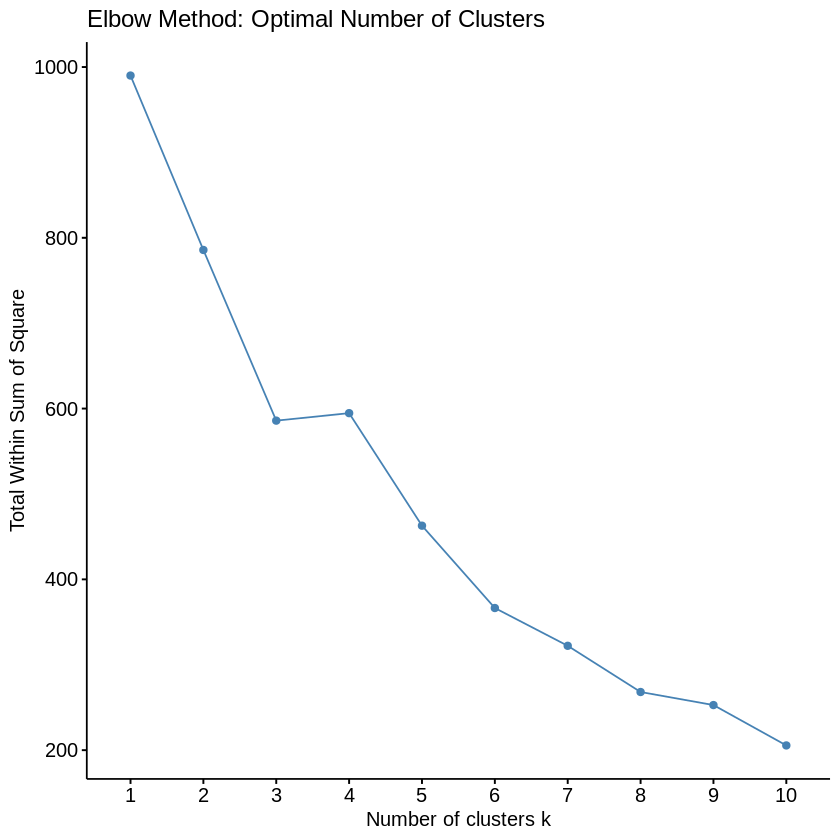

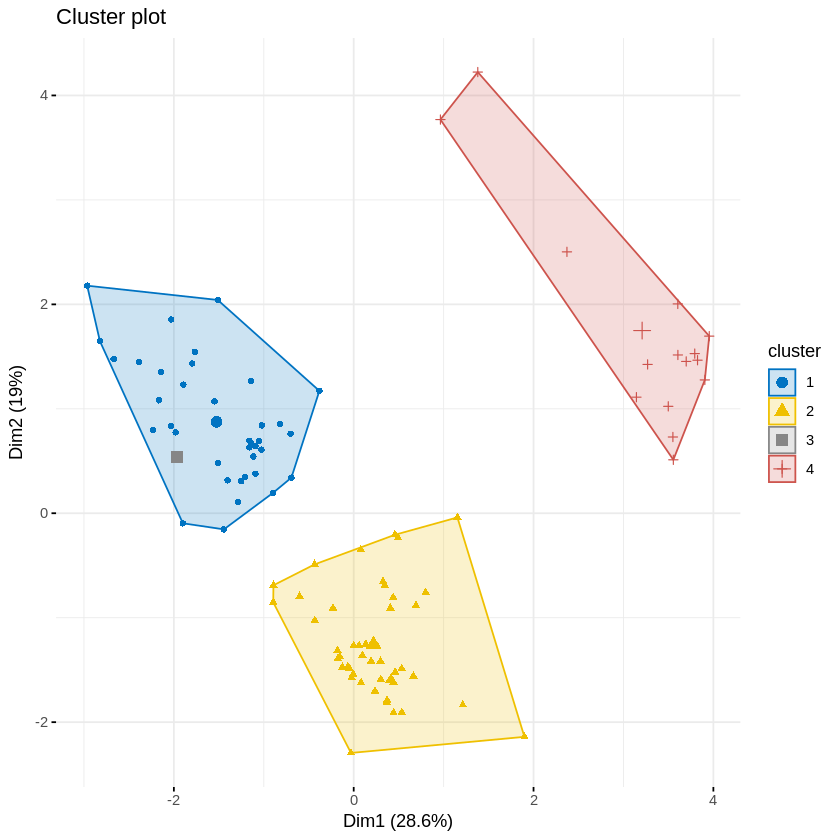

In [ ]:
library(tidyverse)
library(lubridate)
library(cluster)
library(factoextra)

# Drop any unused factor levels
df_cluster <- df_clean %>%
  select(Filing_DayOfYear, Income, Investment_Income, Amount_owed_or_Refund,
         Taxpayer_Age, Dependents, Employment_Type, Filing_Status) %>%
  drop_na() %>%
  mutate(
    Employment_Type = factor(Employment_Type),
    Filing_Status = factor(Filing_Status)
  )

# One-hot encode using model.matrix
one_hot <- model.matrix(~ Employment_Type + Filing_Status - 1, data = df_cluster) %>%
  as.data.frame()

# Combine numeric + encoded data
df_encoded <- bind_cols(
  df_cluster %>% select(-Employment_Type, -Filing_Status),
  one_hot
)

df_scaled <- df_encoded %>%
  mutate(across(everything(), ~ scale(.)[, 1]))


# Use Elbow Method to find optimal k
fviz_nbclust(df_scaled, kmeans, method = "wss") +
  labs(title = "Elbow Method: Optimal Number of Clusters")

# Run K-means
set.seed(123)
k_result <- kmeans(df_scaled, centers = 4, nstart = 25)

# Add cluster labels to the *cleaned* dataset
df_cluster$cluster <- as.factor(k_result$cluster)


# PCA for plotting clusters
fviz_cluster(k_result, data = df_scaled, geom = "point",
             ellipse.type = "convex", palette = "jco", ggtheme = theme_minimal())



In [ ]:
# Cluster Profiling
df_cluster %>%
  group_by(cluster) %>%
  summarise(
    Count = n(),
    Avg_Income = mean(Income, na.rm = TRUE),
    Avg_RefundOrOwed = mean(Amount_owed_or_Refund, na.rm = TRUE),
    Avg_Age = mean(Taxpayer_Age, na.rm = TRUE),
    Avg_Dependents = mean(Dependents, na.rm = TRUE)
  )

# by employment type
df_cluster %>%
  count(cluster, Employment_Type) %>%
  pivot_wider(names_from = Employment_Type, values_from = n, values_fill = 0)


cluster,Count,Avg_Income,Avg_RefundOrOwed,Avg_Age,Avg_Dependents
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,37,37567.57,3481.5946,35.97297,1.7837838
2,47,28437.23,482.1064,30.27660,0.1276596
3,1,49664.00,645.0000,27.00000,1.0000000
4,15,19674.20,-2245.5333,44.40000,0.6000000


cluster,salaried,self-employed
<fct>,<int>,<int>
1,37,0
2,47,0
3,1,0
4,0,15


# Testing K Means

[1] 0.3372319

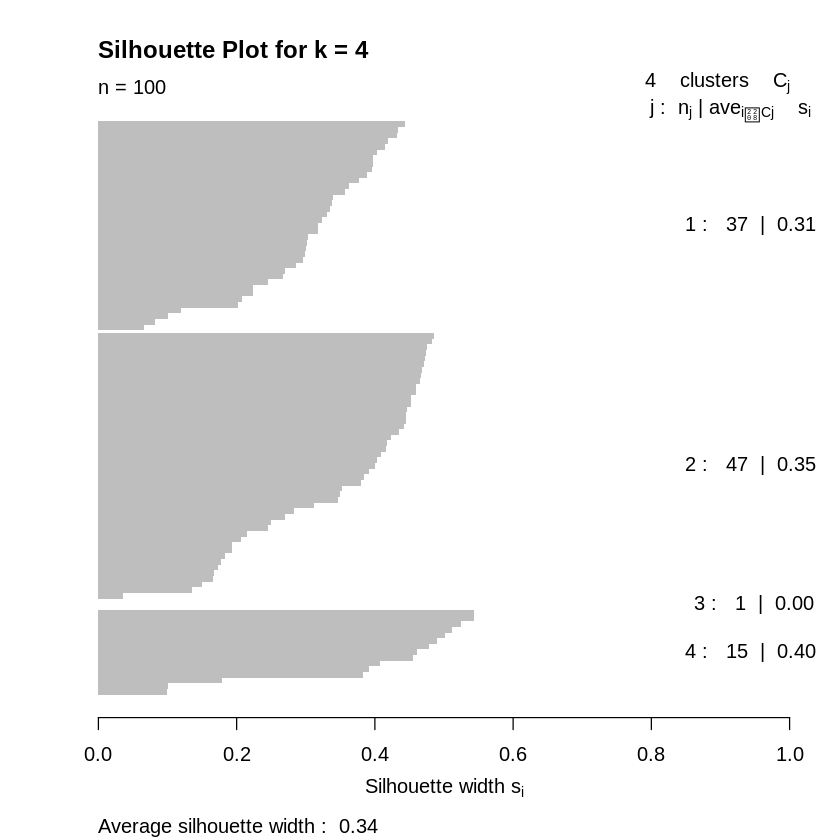

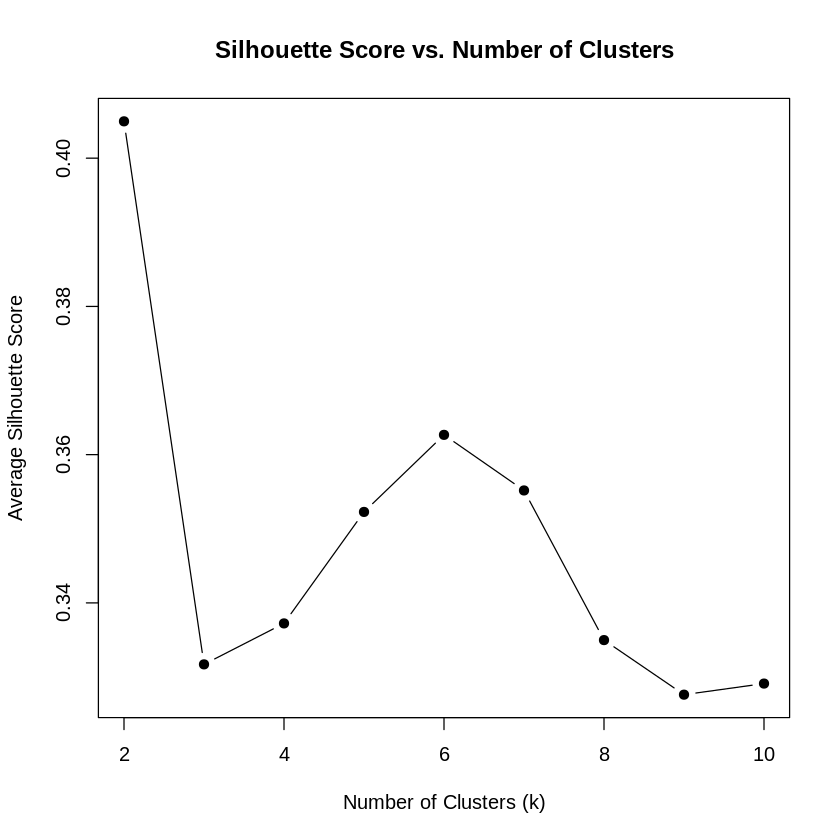

In [ ]:
library(cluster)

# Compute silhouette score for your kmeans clustering
sil <- silhouette(k_result$cluster, dist(df_scaled))

# Visualize
plot(sil, main = "Silhouette Plot for k = 4")

# Get average silhouette width
mean(sil[, 3])


sil_scores <- map_dbl(2:10, function(k) {
  kmeans_model <- kmeans(df_scaled, centers = k, nstart = 25)
  silhouette_score <- silhouette(kmeans_model$cluster, dist(df_scaled))
  mean(silhouette_score[, 3])
})

plot(2:10, sil_scores, type = "b", pch = 19,
     xlab = "Number of Clusters (k)", ylab = "Average Silhouette Score",
     main = "Silhouette Score vs. Number of Clusters")


# More EDA

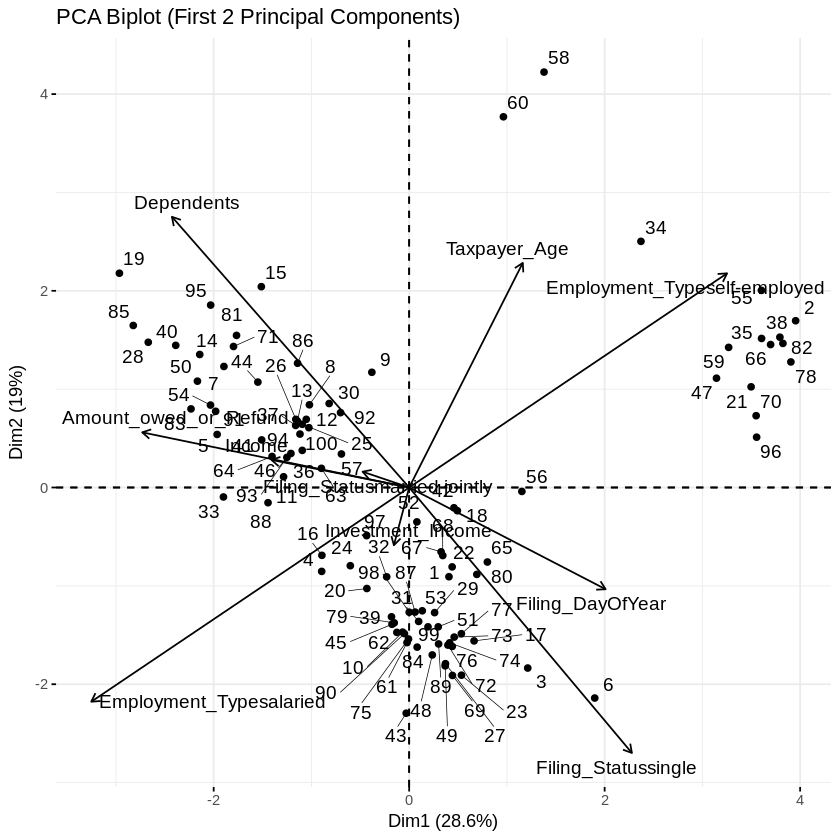

corrplot 0.95 loaded



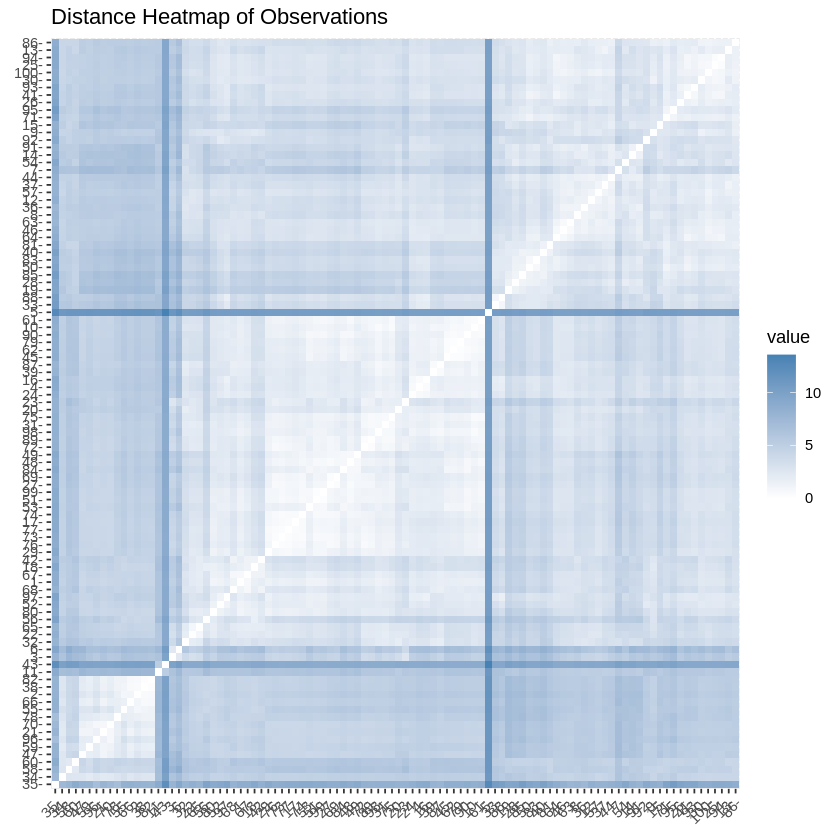


Attaching package: ‘dbscan’


The following object is masked from ‘package:stats’:

    as.dendrogram




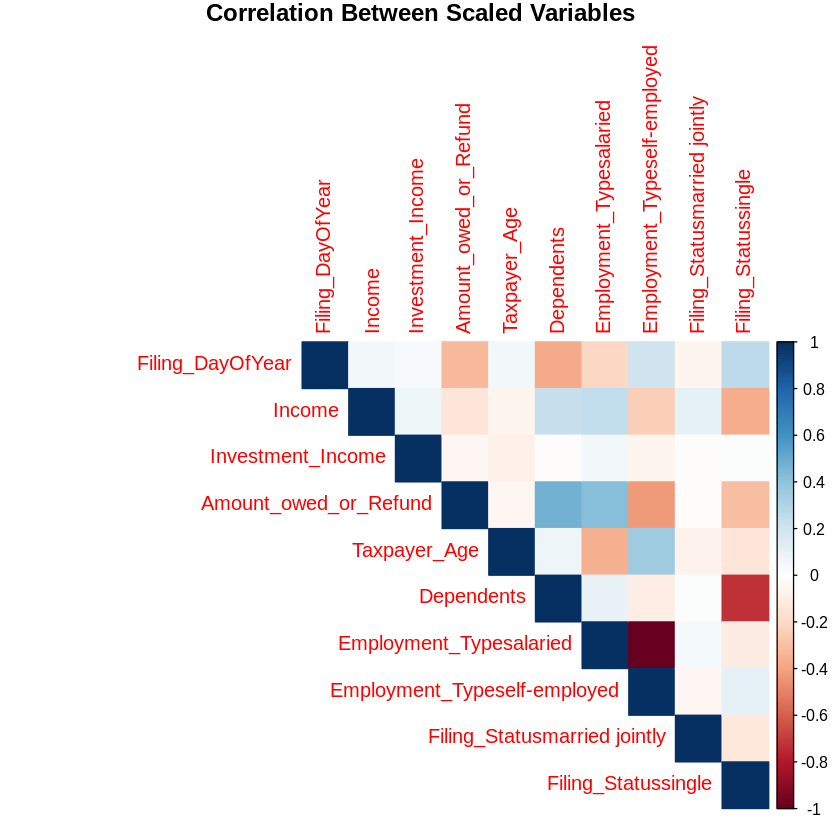

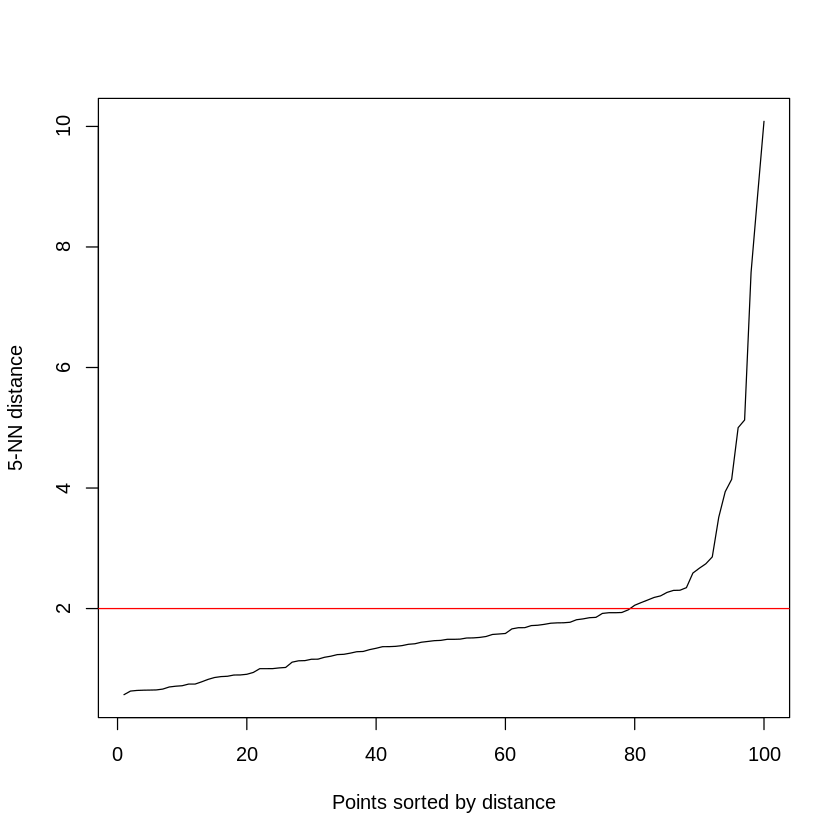

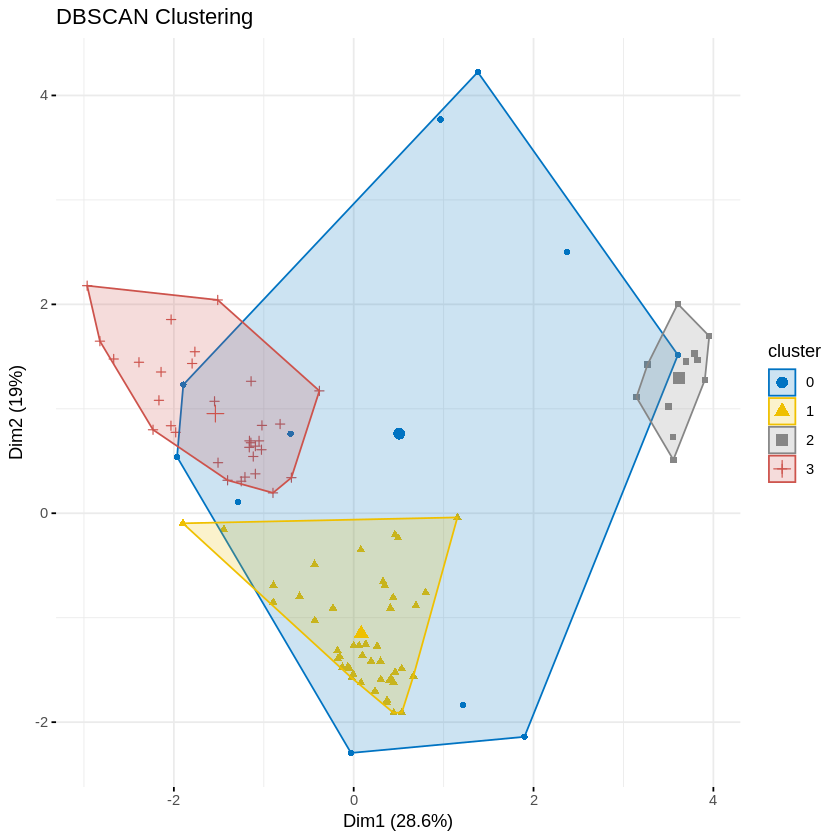

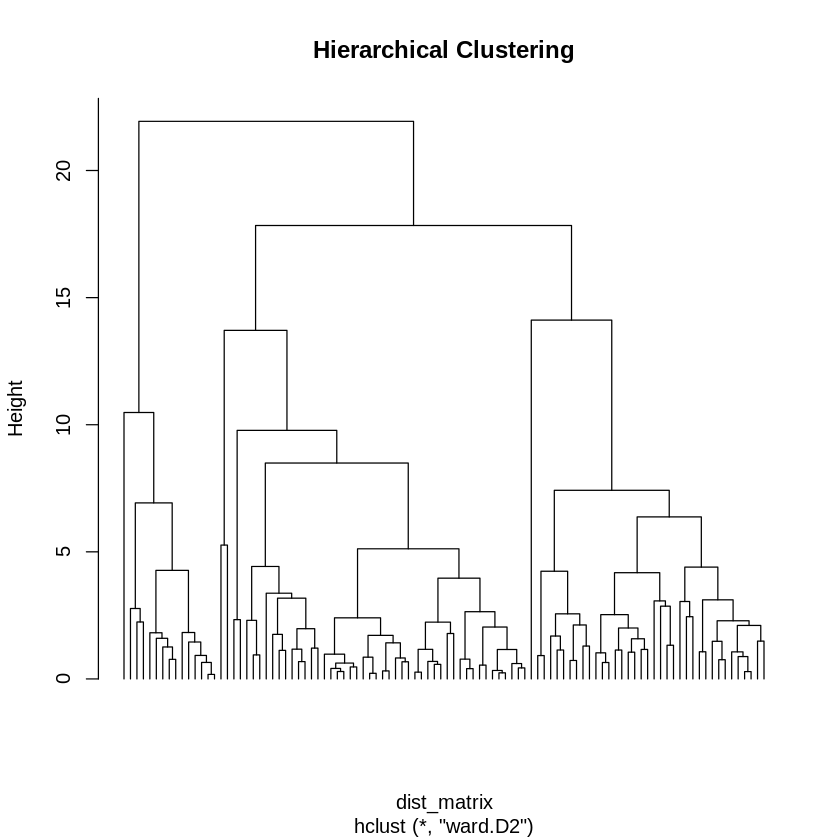

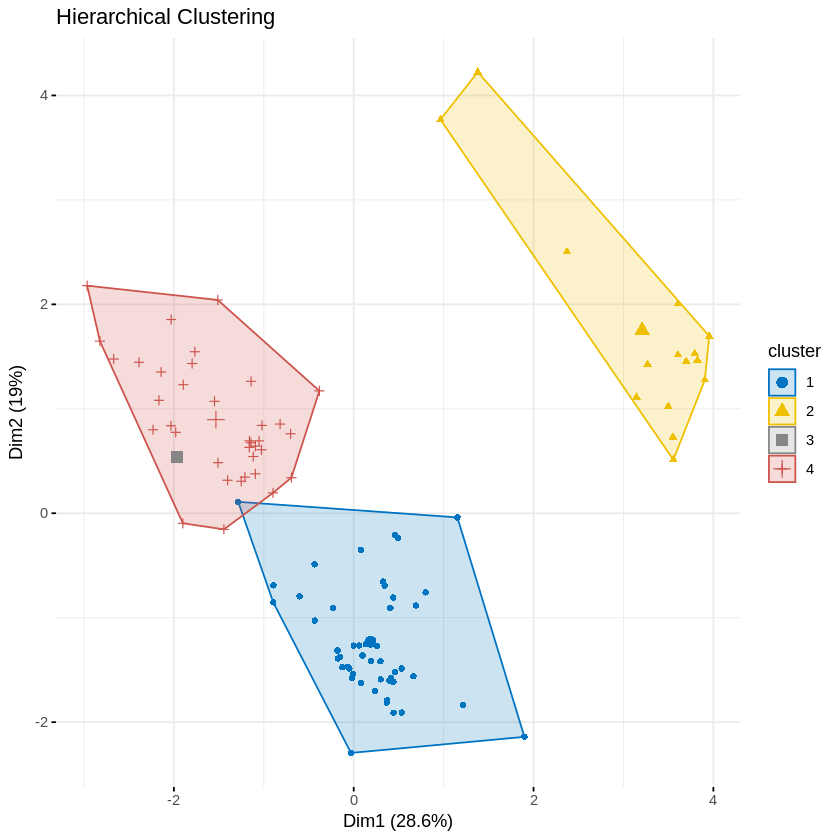

In [ ]:
pca_result <- prcomp(df_scaled)

library(factoextra)
fviz_pca_biplot(pca_result, repel = TRUE,
                title = "PCA Biplot (First 2 Principal Components)",
                col.var = "black")

fviz_dist(dist(df_scaled),
          gradient = list(low = "white", high = "steelblue")) +
  ggtitle("Distance Heatmap of Observations")


library(corrplot)
corrplot(cor(df_scaled), method = "color", type = "upper",
         title = "Correlation Between Scaled Variables", mar = c(0,0,1,0))

library(dbscan)

# Tune eps manually or use kNNdistplot to find knee point
kNNdistplot(df_scaled, k = 5)
abline(h = 2, col = "red")  # can adjust this value

# DBSCAN
db <- dbscan(df_scaled, eps = 2, minPts = 5)

# cluster labels
df_cluster$dbscan_cluster <- as.factor(db$cluster)

fviz_cluster(list(data = df_scaled, cluster = db$cluster),
             geom = "point", palette = "jco", ggtheme = theme_minimal(),
             main = "DBSCAN Clustering")

dist_matrix <- dist(df_scaled)
hc <- hclust(dist_matrix, method = "ward.D2")

# Plot dendrogram
plot(hc, labels = FALSE, hang = -1, main = "Hierarchical Clustering")

# Cut tree into 4 clusters (or tune)
hc_labels <- cutree(hc, k = 4)
df_cluster$hclust_cluster <- as.factor(hc_labels)

fviz_cluster(list(data = df_scaled, cluster = hc_labels),
             geom = "point", palette = "jco", ggtheme = theme_minimal(),
             main = "Hierarchical Clustering")


In [ ]:
# Run KMeans for k = 2 and k = 4
km2 <- kmeans(df_scaled, centers = 2, nstart = 25)
km4 <- kmeans(df_scaled, centers = 4, nstart = 25)

# Compare silhouette
mean(silhouette(km2$cluster, dist(df_scaled))[, 3])
mean(silhouette(km4$cluster, dist(df_scaled))[, 3])

[1] 0.4049717

[1] 0.3372319

# Testing other clustering algorithms

In [ ]:
# Test other cluster algorithms
library(cluster)
library(factoextra)
library(mclust)
library(dbscan)
library(dendextend)
library(clusterCrit)

silhouette_scores <- list()
ch_scores <- list()
dunn_scores <- list()

# K-means
set.seed(123)
kmeans_model <- kmeans(df_scaled, centers = 4, nstart = 25)
k_labels <- kmeans_model$cluster
silhouette_scores$kmeans <- mean(silhouette(k_labels, dist(df_scaled))[, 3])

int_k <- intCriteria(as.matrix(df_scaled), k_labels,
                     c("Calinski_Harabasz", "Dunn"))
ch_scores$kmeans <- int_k$calinski_harabasz
dunn_scores$kmeans <- int_k$dunn

# GMM
gmm_model <- Mclust(df_scaled, G = 2:6)
gmm_labels <- gmm_model$classification

if (length(unique(gmm_labels)) > 1) {
  silhouette_scores$gmm <- mean(silhouette(gmm_labels, dist(df_scaled))[, 3])

  int_gmm <- intCriteria(as.matrix(df_scaled), as.integer(gmm_labels),
                         c("Calinski_Harabasz", "Dunn"))
  ch_scores$gmm <- int_gmm$calinski_harabasz
  dunn_scores$gmm <- int_gmm$dunn
} else {
  silhouette_scores$gmm <- NA
  ch_scores$gmm <- NA
  dunn_scores$gmm <- NA
}

# Hierarchical Clustering
hc <- hclust(dist(df_scaled), method = "ward.D2")
hc_labels <- cutree(hc, k = 4)
silhouette_scores$hierarchical <- mean(silhouette(hc_labels, dist(df_scaled))[, 3])

int_hc <- intCriteria(as.matrix(df_scaled), hc_labels,
                      c("Calinski_Harabasz", "Dunn"))
ch_scores$hierarchical <- int_hc$calinski_harabasz
dunn_scores$hierarchical <- int_hc$dunn

# DBSCAN
eps_val <- 2
minPts_val <- 5
db_model <- dbscan(df_scaled, eps = eps_val, minPts = minPts_val)
db_labels <- db_model$cluster

# Remove noise points (cluster == 0)
valid <- db_labels != 0
if (length(unique(db_labels[valid])) > 1) {
  dist_mat <- as.matrix(dist(df_scaled))
  silhouette_scores$dbscan <- mean(silhouette(db_labels[valid], dist_mat[valid, valid])[, 3])

  int_db <- intCriteria(as.matrix(df_scaled[valid, ]), db_labels[valid],
                        c("Calinski_Harabasz", "Dunn"))
  ch_scores$dbscan <- int_db$calinski_harabasz
  dunn_scores$dbscan <- int_db$dunn
} else {
  silhouette_scores$dbscan <- NA
  ch_scores$dbscan <- NA
  dunn_scores$dbscan <- NA
}

cat("Silhouette Scores (Higher = Better):\n")
print(round(unlist(silhouette_scores), 3))

cat("\nCalinski-Harabasz Index (Higher = Better):\n")
print(round(unlist(ch_scores), 1))

cat("\nDunn Index (Higher = Better):\n")
print(round(unlist(dunn_scores), 3))

Silhouette Scores (Higher = Better):
      kmeans          gmm hierarchical       dbscan 
       0.337        0.228        0.331        0.409 

Calinski-Harabasz Index (Higher = Better):
      kmeans          gmm hierarchical       dbscan 
        33.1         16.7         32.6         64.3 

Dunn Index (Higher = Better):
      kmeans          gmm hierarchical       dbscan 
       0.156        0.043        0.156        0.375 


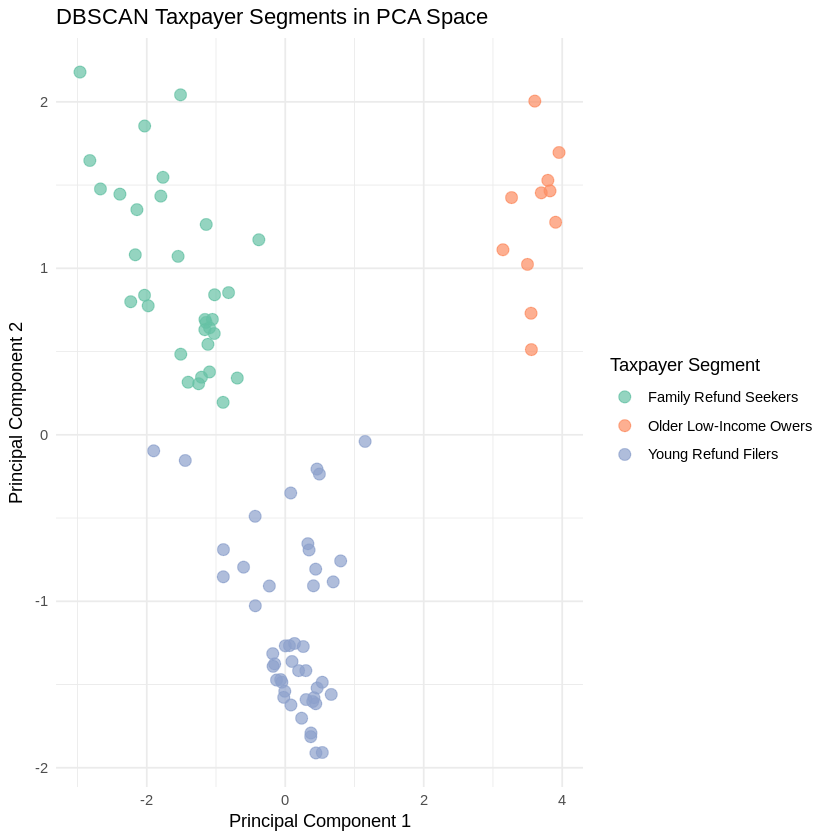

In [ ]:
pca <- prcomp(df_scaled)
pca_df <- as.data.frame(pca$x[, 1:2])  # Keep only first 2 components
colnames(pca_df) <- c("PC1", "PC2")

pca_df$cluster_id <- db_model$cluster
pca_df <- pca_df %>% filter(cluster_id != 0)  # remove noise

label_map <- c(
  "1" = "Young Refund Filers",
  "2" = "Older Low-Income Owers",
  "3" = "Family Refund Seekers"
)
pca_df$cluster_label <- label_map[as.character(pca_df$cluster_id)]

library(ggplot2)
ggplot(pca_df, aes(x = PC1, y = PC2, color = cluster_label)) +
  geom_point(alpha = 0.7, size = 3) +
  theme_minimal() +
  labs(title = "DBSCAN Taxpayer Segments in PCA Space",
       x = "Principal Component 1", y = "Principal Component 2",
       color = "Taxpayer Segment") +
  scale_color_brewer(palette = "Set2")

#  dbscan_cluster count avg_income avg_refund avg_age avg_dependents
#   <fct>          <int>      <dbl>      <dbl>   <dbl>          <dbl>
# 1 1                 46     26992.       892.    29.9         0.217
# 2 2                 11     12559.     -1567.    46.4         0.0909
# 3 3                 32     36378.      3399.    36.2         1.75

# cluster 1	"Young Refund Filers"	Young (avg age 30), low income ($27K), low dependents, modest refunds
# cluster 2	"Older Low-Income Owers"	Older (avg 46), lowest income ($12.5K), owe tax, nearly no dependents
# cluster 3	"Family Refund Seekers"	Mid-aged (36), higher income ($36K), high refunds, many dependents


# Testing classification

In [ ]:
library(tidyverse)
install.packages("caret")
library(caret)
library(randomForest)

# Create binary target: 1 = refund, 0 = owes
df_class <- df_clean %>%
  mutate(
    refund_flag = ifelse(Amount_owed_or_Refund > 0, 1, 0),
    Employment_Type = factor(Employment_Type),
    Filing_Status = factor(Filing_Status)
  ) %>%
  select(refund_flag, Income, Investment_Income, Taxpayer_Age, Dependents,
         Employment_Type, Filing_Status) %>%
  drop_na()

library(caret)

dv <- dummyVars(refund_flag ~ ., data = df_class)

df_all_dummies <- predict(dv, newdata = df_class) %>% as.data.frame()
df_all_dummies$refund_flag <- df_class$refund_flag

set.seed(123)
train_index <- createDataPartition(df_all_dummies$refund_flag, p = 0.8, list = FALSE)
train_data <- df_all_dummies[train_index, ]
test_data <- df_all_dummies[-train_index, ]



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message in install.packages("caret"):
“installation of package ‘caret’ had non-zero exit status”


In [ ]:
# Log
log_model <- glm(refund_flag ~ ., data = train_data, family = binomial)

log_probs <- predict(log_model, test_data, type = "response")
log_preds <- ifelse(log_probs > 0.5, 1, 0)

confusionMatrix(as.factor(log_preds), as.factor(test_data$refund_flag))


# Separate features and labels
x_train <- train_data %>% select(-refund_flag)
y_train <- as.factor(train_data$refund_flag)

x_test <- test_data %>% select(-refund_flag)
y_test <- as.factor(test_data$refund_flag)

# Train Random Forest
rf_model <- randomForest(x = x_train, y = y_train, ntree = 100)

rf_preds <- predict(rf_model, x_test)

confusionMatrix(rf_preds, y_test)



Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0  4  1
         1  3 12
                                          
               Accuracy : 0.8             
                 95% CI : (0.5634, 0.9427)
    No Information Rate : 0.65            
    P-Value [Acc > NIR] : 0.1182          
                                          
                  Kappa : 0.5294          
                                          
 Mcnemar's Test P-Value : 0.6171          
                                          
            Sensitivity : 0.5714          
            Specificity : 0.9231          
         Pos Pred Value : 0.8000          
         Neg Pred Value : 0.8000          
             Prevalence : 0.3500          
         Detection Rate : 0.2000          
   Detection Prevalence : 0.2500          
      Balanced Accuracy : 0.7473          
                                          
       'Positive' Class : 0               
                                    

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0  4  0
         1  3 13
                                          
               Accuracy : 0.85            
                 95% CI : (0.6211, 0.9679)
    No Information Rate : 0.65            
    P-Value [Acc > NIR] : 0.04438         
                                          
                  Kappa : 0.6341          
                                          
 Mcnemar's Test P-Value : 0.24821         
                                          
            Sensitivity : 0.5714          
            Specificity : 1.0000          
         Pos Pred Value : 1.0000          
         Neg Pred Value : 0.8125          
             Prevalence : 0.3500          
         Detection Rate : 0.2000          
   Detection Prevalence : 0.2000          
      Balanced Accuracy : 0.7857          
                                          
       'Positive' Class : 0               
                                    

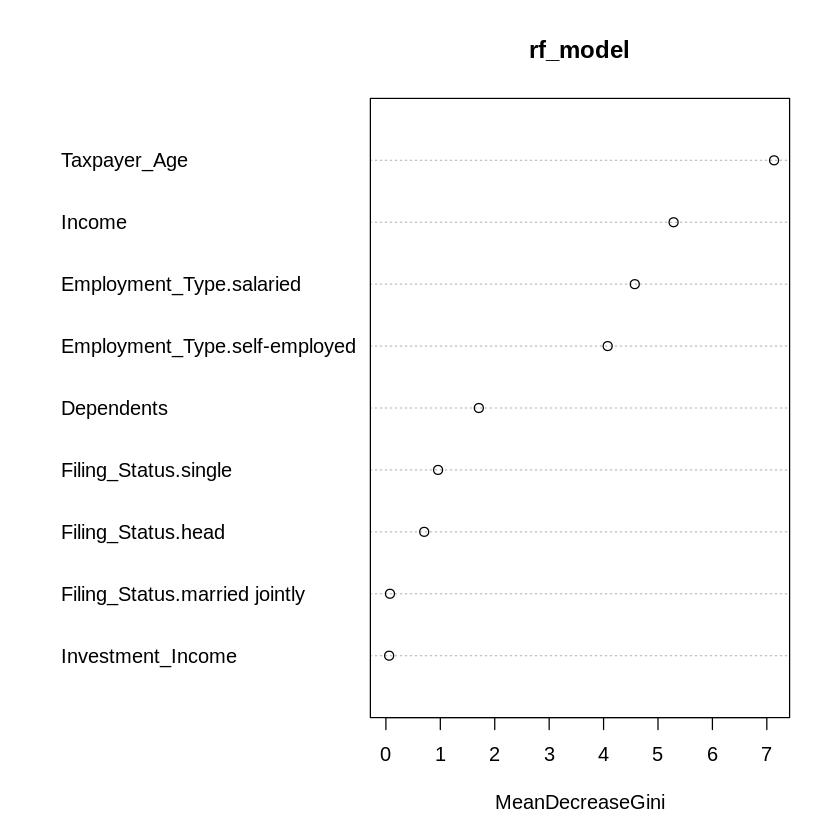

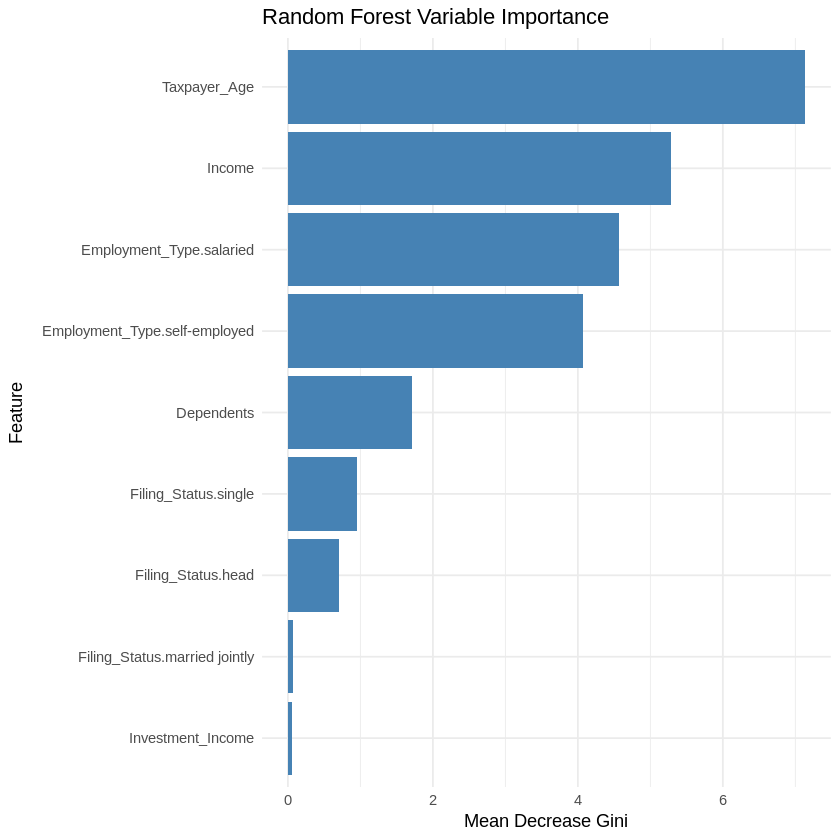

In [ ]:
# Variable importance plot
varImpPlot(rf_model)

rf_importance <- importance(rf_model)
importance_df <- data.frame(Feature = rownames(rf_importance),
                            Importance = rf_importance[, "MeanDecreaseGini"])

library(ggplot2)

ggplot(importance_df, aes(x = reorder(Feature, Importance), y = Importance)) +
  geom_col(fill = "steelblue") +
  coord_flip() +
  labs(title = "Random Forest Variable Importance",
       x = "Feature", y = "Mean Decrease Gini") +
  theme_minimal()


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘mltools’


The following object is masked from ‘package:tidyr’:

    replace_na



Attaching package: ‘data.table’


The following object is masked from ‘package:rlang’:

    :=


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following object is masked from ‘package:purrr’:

    transpose


The following objects are masked from ‘package:dplyr’:

    between, first, last




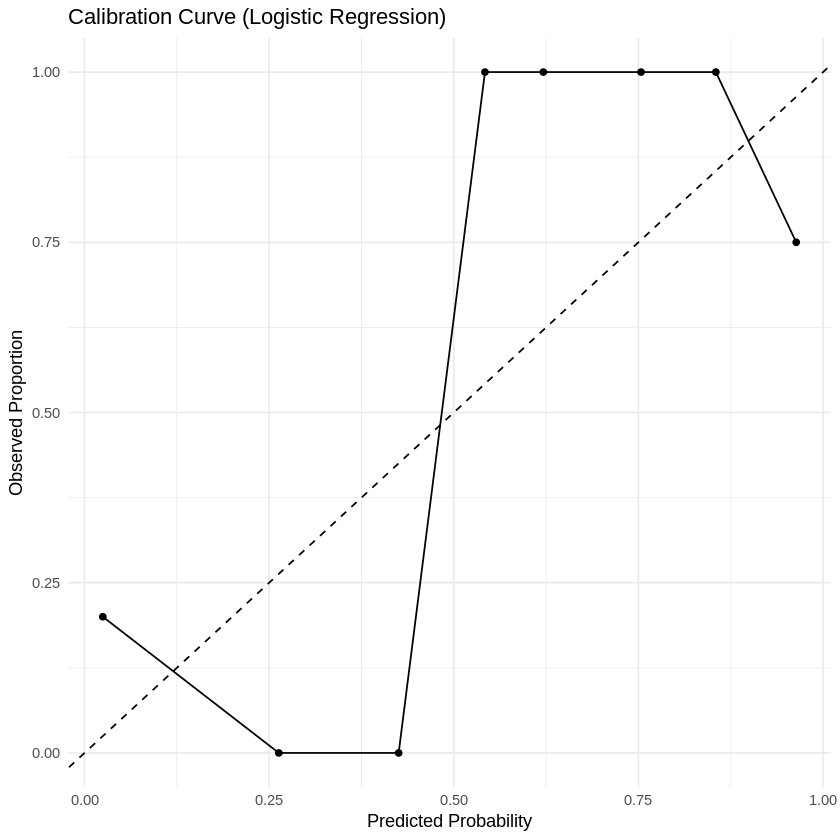

In [ ]:
library(ggplot2)
library(caret)
install.packages("mltools")
library(mltools)
library(data.table)

# Create calibration data
cal_data <- data.frame(prob = log_probs, actual = test_data$refund_flag)

# Bin predicted probabilities into 10 groups
cal_data$bin <- cut(cal_data$prob, breaks = seq(0, 1, by = 0.1), include.lowest = TRUE)

# Compute average predicted prob and actual rate in each bin
cal_plot_data <- cal_data %>%
  group_by(bin) %>%
  summarise(mean_prob = mean(prob), actual_rate = mean(actual))

# Plot calibration curve
ggplot(cal_plot_data, aes(x = mean_prob, y = actual_rate)) +
  geom_line() +
  geom_point() +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed") +
  labs(title = "Calibration Curve (Logistic Regression)",
       x = "Predicted Probability", y = "Observed Proportion") +
  theme_minimal()


In [ ]:
install.packages("InformationValue")

library(InformationValue)
library(ggplot2)

# For logistic regression predictions ---------------------
# Create lift and gain data for logistic regression
log_lift <- gainLift(log_probs, test_data$refund_flag, groups = 10)

# Plot Cumulative Gains Chart
ggplot(log_lift, aes(x = bucket, y = cumulativePctCapturedResponse)) +
  geom_line(color = "steelblue", size = 1.2) +
  geom_point(size = 2) +
  geom_abline(slope = 10, intercept = 0, linetype = "dashed") +
  labs(title = "Cumulative Gains Chart - Logistic Regression",
       x = "Decile (10 = highest probability group)",
       y = "Cumulative % of Refunds Captured") +
  theme_minimal()

# Plot Lift Chart
ggplot(log_lift, aes(x = bucket, y = lift)) +
  geom_line(color = "darkorange", size = 1.2) +
  geom_point(size = 2) +
  labs(title = "Lift Chart - Logistic Regression",
       x = "Decile (10 = highest probability group)",
       y = "Lift") +
  theme_minimal()


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“package ‘InformationValue’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”


ERROR: Error in library(InformationValue): there is no package called ‘InformationValue’


Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



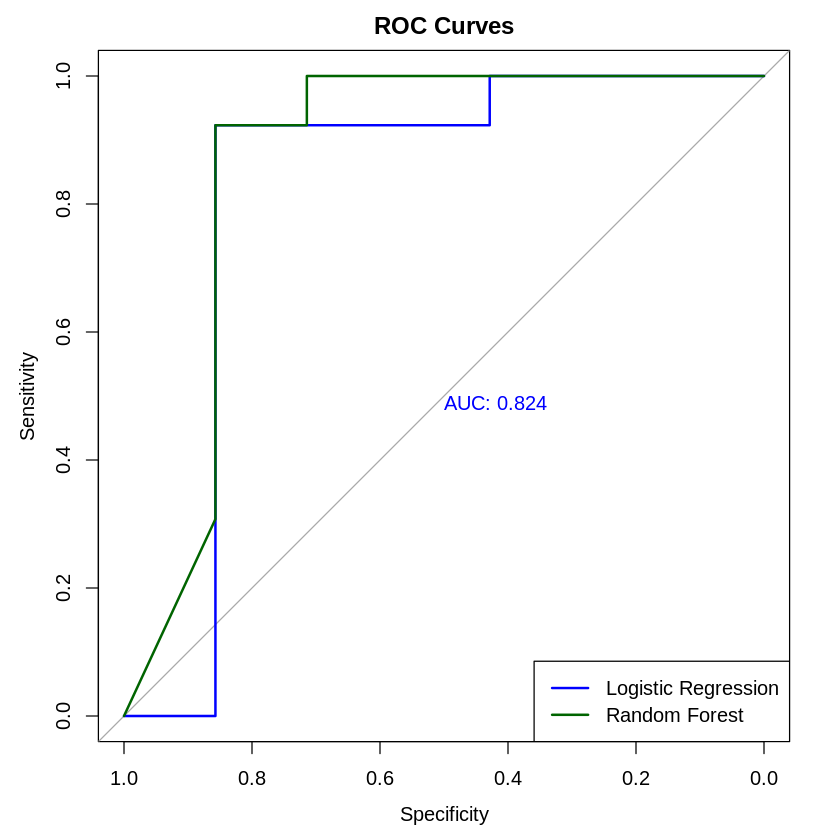

In [ ]:
library(pROC)

# Logistic regression ROC
log_roc <- roc(test_data$refund_flag, log_probs)

# Random Forest ROC
rf_probs <- predict(rf_model, x_test, type = "prob")[, 2]  # probability for class 1
rf_roc <- roc(test_data$refund_flag, rf_probs)

# Plot both
plot(log_roc, col = "blue", print.auc = TRUE, main = "ROC Curves")
lines(rf_roc, col = "darkgreen")
legend("bottomright", legend = c("Logistic Regression", "Random Forest"),
       col = c("blue", "darkgreen"), lwd = 2)


In [ ]:
# Calculate class weights (inverse frequency)
class_counts <- table(train_data$refund_flag)
total <- sum(class_counts)
class_weights <- total / (2 * class_counts)  # 2 = number of classes

# Assign weights to each training row
log_weights <- sapply(train_data$refund_flag, function(x) class_weights[as.character(x)])

log_model <- glm(refund_flag ~ ., data = train_data, family = binomial, weights = log_weights)

log_probs <- predict(log_model, test_data, type = "response")
log_preds <- ifelse(log_probs > 0.5, 1, 0)

confusionMatrix(as.factor(log_preds), as.factor(test_data$refund_flag))

library(caret)
library(randomForest)

# Upsample minority class
train_data_balanced <- upSample(
  x = train_data %>% select(-refund_flag),
  y = as.factor(train_data$refund_flag),
  yname = "refund_flag"
)

# Use matrix interface instead of formula
x_train_bal <- train_data_balanced %>% select(-refund_flag)
y_train_bal <- train_data_balanced$refund_flag

x_test <- test_data %>% select(-refund_flag)
y_test <- as.factor(test_data$refund_flag)

rf_model <- randomForest(x = x_train_bal, y = y_train_bal, ntree = 100)

rf_preds <- predict(rf_model, x_test)

confusionMatrix(rf_preds, y_test)



Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”


Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0  6  1
         1  1 12
                                         
               Accuracy : 0.9            
                 95% CI : (0.683, 0.9877)
    No Information Rate : 0.65           
    P-Value [Acc > NIR] : 0.01212        
                                         
                  Kappa : 0.7802         
                                         
 Mcnemar's Test P-Value : 1.00000        
                                         
            Sensitivity : 0.8571         
            Specificity : 0.9231         
         Pos Pred Value : 0.8571         
         Neg Pred Value : 0.9231         
             Prevalence : 0.3500         
         Detection Rate : 0.3000         
   Detection Prevalence : 0.3500         
      Balanced Accuracy : 0.8901         
                                         
       'Positive' Class : 0              
                                         

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0  6  0
         1  1 13
                                          
               Accuracy : 0.95            
                 95% CI : (0.7513, 0.9987)
    No Information Rate : 0.65            
    P-Value [Acc > NIR] : 0.002133        
                                          
                  Kappa : 0.8864          
                                          
 Mcnemar's Test P-Value : 1.000000        
                                          
            Sensitivity : 0.8571          
            Specificity : 1.0000          
         Pos Pred Value : 1.0000          
         Neg Pred Value : 0.9286          
             Prevalence : 0.3500          
         Detection Rate : 0.3000          
   Detection Prevalence : 0.3000          
      Balanced Accuracy : 0.9286          
                                          
       'Positive' Class : 0               
                                    

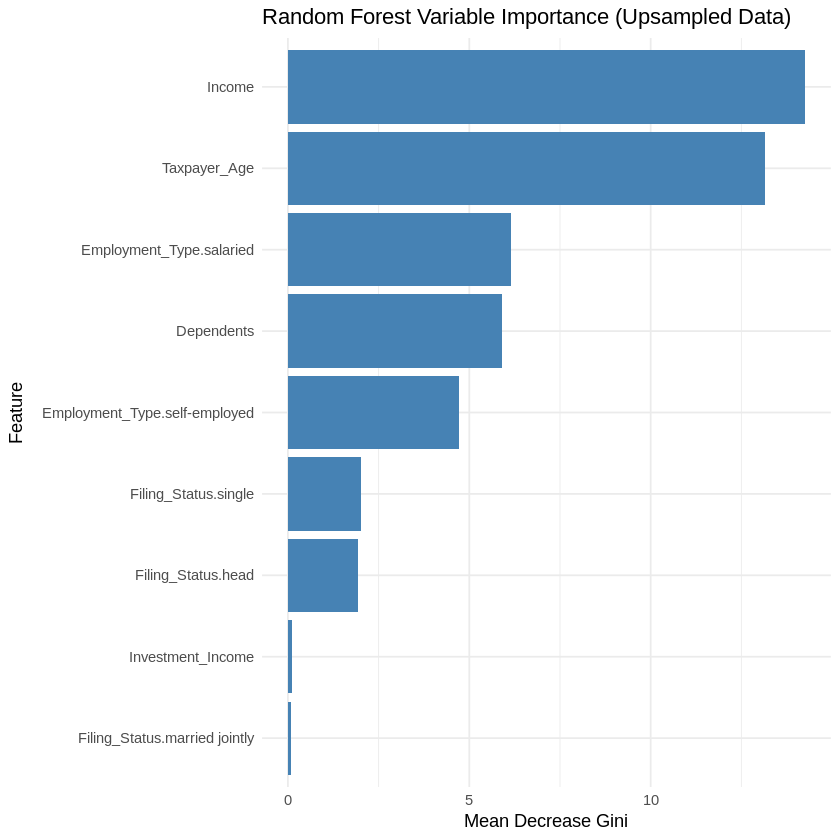

In [ ]:
rf_importance <- importance(rf_model)
importance_df <- data.frame(Feature = rownames(rf_importance),
                            Importance = rf_importance[, "MeanDecreaseGini"])

library(ggplot2)

ggplot(importance_df, aes(x = reorder(Feature, Importance), y = Importance)) +
  geom_col(fill = "steelblue") +
  coord_flip() +
  labs(title = "Random Forest Variable Importance (Upsampled Data)",
       x = "Feature", y = "Mean Decrease Gini") +
  theme_minimal()


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



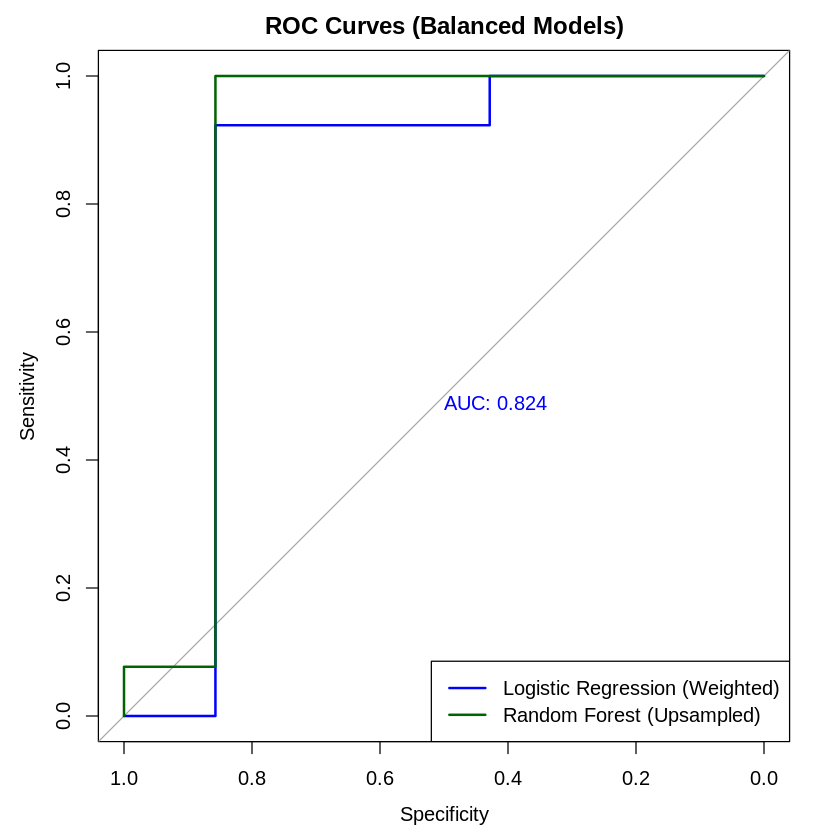

In [ ]:
library(pROC)

# Logistic regression ROC
log_roc <- roc(test_data$refund_flag, log_probs)

# Random Forest ROC (we need probabilities for class 1)
rf_probs <- predict(rf_model, x_test, type = "prob")[, 2]
rf_roc <- roc(test_data$refund_flag, rf_probs)

# Plot both ROC curves
plot(log_roc, col = "blue", print.auc = TRUE, main = "ROC Curves (Balanced Models)")
lines(rf_roc, col = "darkgreen")
legend("bottomright", legend = c("Logistic Regression (Weighted)", "Random Forest (Upsampled)"),
       col = c("blue", "darkgreen"), lwd = 2)


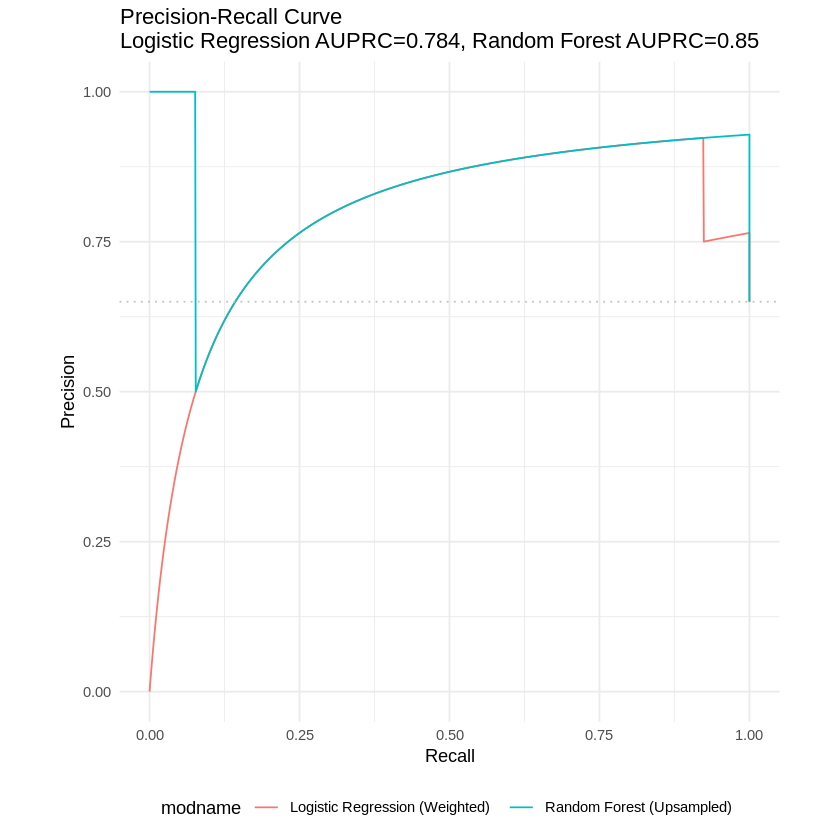

In [ ]:
library(precrec)
library(ggplot2)

# Scores and true labels
log_scores <- log_probs
rf_scores <- predict(rf_model, x_test, type = "prob")[, 2]

# Prepare data for both models
mmdata_obj <- mmdata(
  scores = list(log_scores, rf_scores),
  labels = list(test_data$refund_flag, test_data$refund_flag),
  modnames = c("Logistic Regression (Weighted)", "Random Forest (Upsampled)")
)

# Evaluate Precision-Recall only
evalmod_obj <- evalmod(mmdata_obj)

# Calculate AUPRC
auc_vals <- auc(evalmod_obj)
pr_auc <- auc_vals[auc_vals$curvetypes == "PRC", ]

# Plot Precision-Recall curve only
pr_plot <- autoplot(evalmod_obj, "PRC") +
  ggtitle(paste0("Precision-Recall Curve\n",
                 "Logistic Regression AUPRC=", round(pr_auc$aucs[1], 3),
                 ", Random Forest AUPRC=", round(pr_auc$aucs[2], 3))) +
  theme_minimal() +
  theme(legend.position = "bottom")

pr_plot


In [ ]:
nrow(df_class)

[1] 100

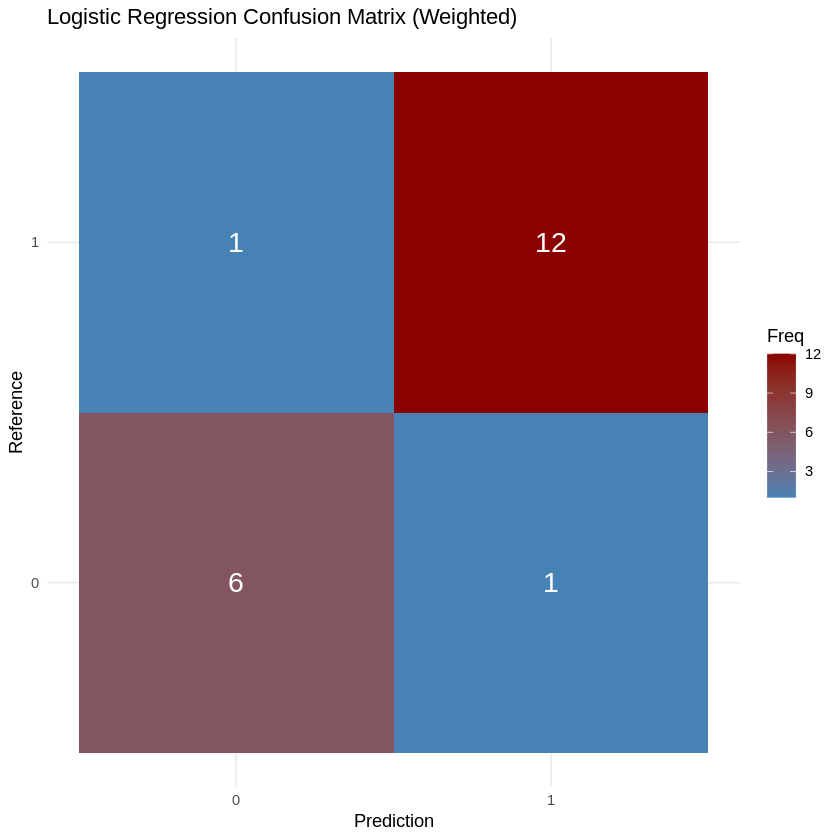

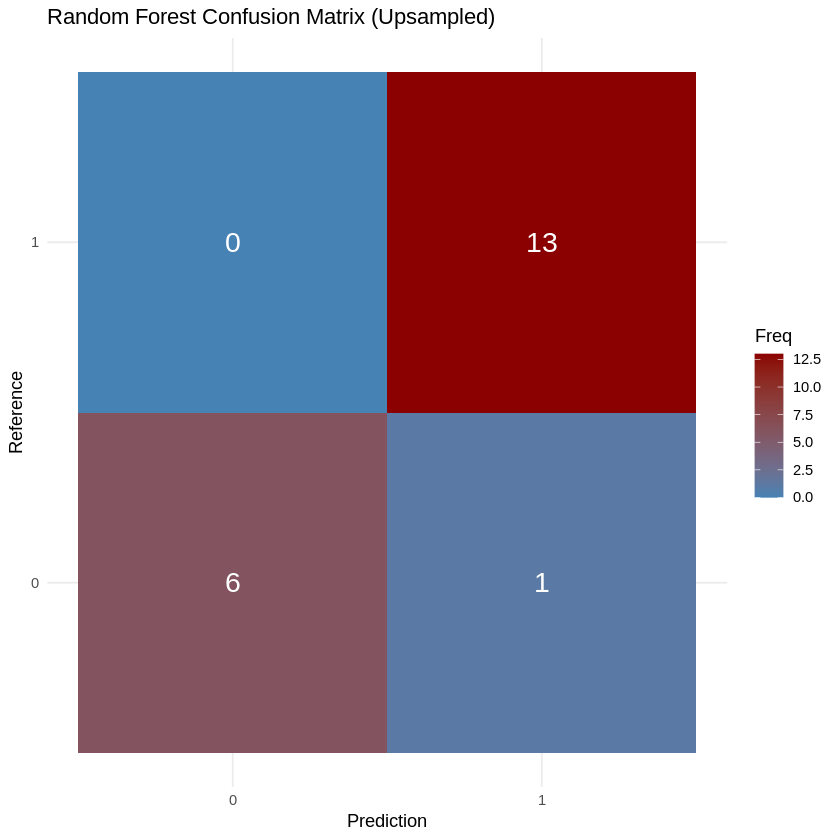

In [ ]:
# Logistic Regression confusion matrix
log_cm <- confusionMatrix(as.factor(log_preds), as.factor(test_data$refund_flag))
log_cm_table <- as.data.frame(log_cm$table)

ggplot(log_cm_table, aes(Prediction, Reference, fill = Freq)) +
  geom_tile() +
  geom_text(aes(label = Freq), color = "white", size = 6) +
  scale_fill_gradient(low = "steelblue", high = "darkred") +
  labs(title = "Logistic Regression Confusion Matrix (Weighted)") +
  theme_minimal()

# Random Forest confusion matrix
rf_cm <- confusionMatrix(rf_preds, y_test)
rf_cm_table <- as.data.frame(rf_cm$table)

ggplot(rf_cm_table, aes(Prediction, Reference, fill = Freq)) +
  geom_tile() +
  geom_text(aes(label = Freq), color = "white", size = 6) +
  scale_fill_gradient(low = "steelblue", high = "darkred") +
  labs(title = "Random Forest Confusion Matrix (Upsampled)") +
  theme_minimal()


In [ ]:
nrow(df_class)

[1] 100

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



AUC - Logistic Regression: 0.824 
AUC - Random Forest: 0.863 
Logistic PR AUC: 0.825 


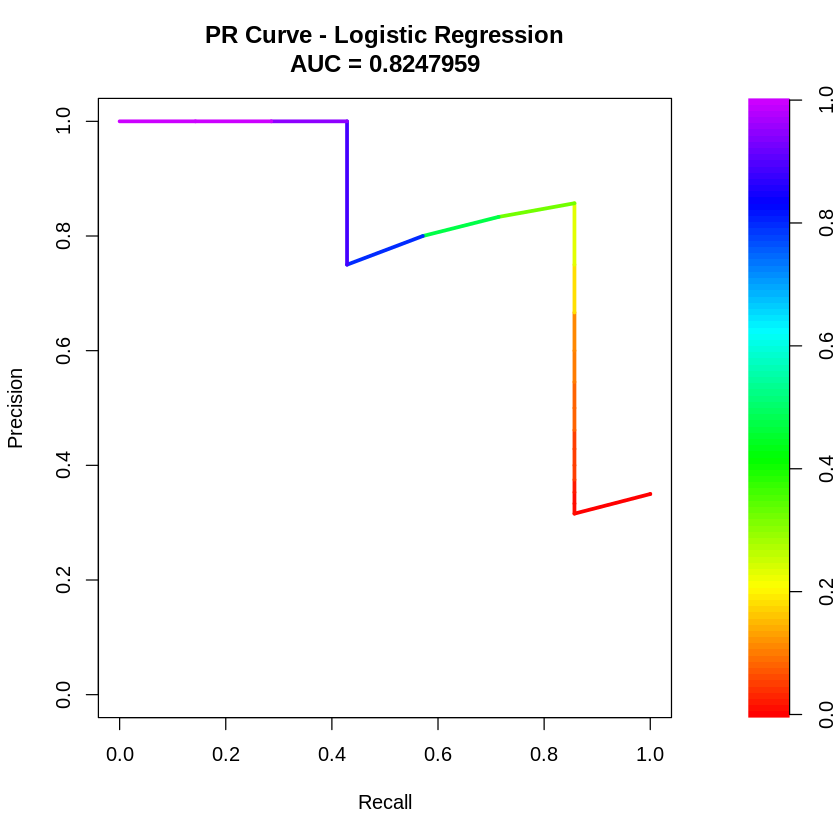

Random Forest PR AUC: 0.232 


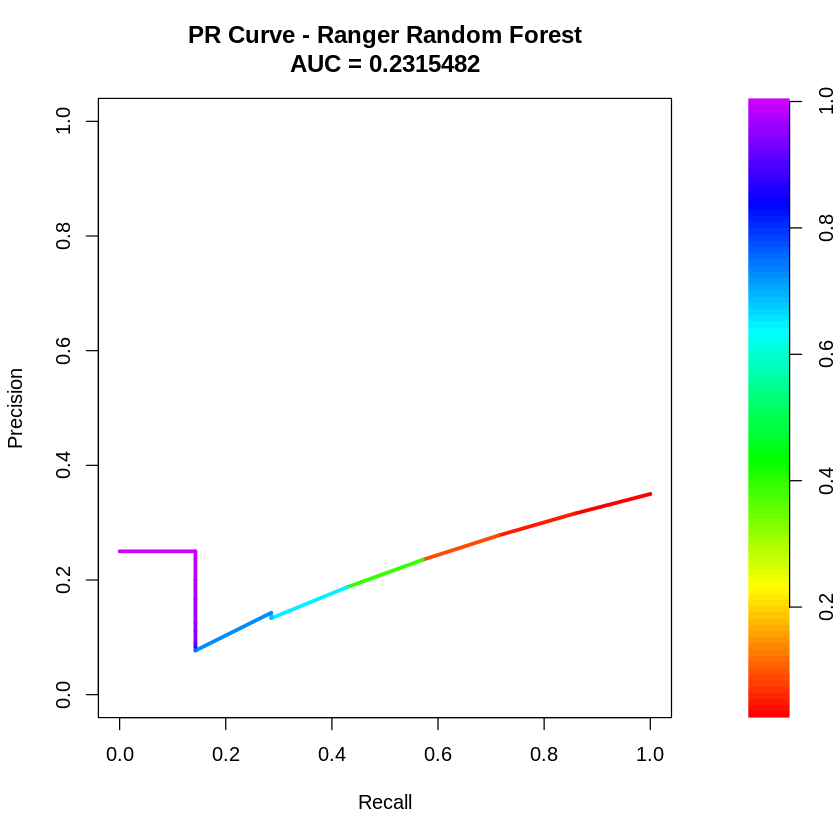

In [ ]:
library(pROC)

# Logistic AUC
roc_log <- roc(test_data$refund_flag, log_probs)
auc_log <- auc(roc_log)

# Random Forest AUC
rf_probs <- predict(rf_model, test_data, type = "prob")[, 2]
roc_rf <- roc(test_data$refund_flag, rf_probs)
auc_rf <- auc(roc_rf)

cat("AUC - Logistic Regression:", round(auc_log, 3), "\n")
cat("AUC - Random Forest:", round(auc_rf, 3), "\n")

library(PRROC)

# Probabilities for class 0 (owes money)
log_probs_class0 <- 1 - log_probs

pr_log <- pr.curve(
  scores.class0 = log_probs_class0[test_data$refund_flag == 0],
  scores.class1 = log_probs_class0[test_data$refund_flag == 1],
  curve = TRUE
)

plot(pr_log, main = "PR Curve - Logistic Regression")
cat("Logistic PR AUC:", round(pr_log$auc.integral, 3), "\n")

pr_rf <- pr.curve(
  scores.class0 = rf_probs[test_data$refund_flag == 0],
  scores.class1 = rf_probs[test_data$refund_flag == 1],
  curve = TRUE
)

plot(pr_rf, main = "PR Curve - Ranger Random Forest")
cat("Random Forest PR AUC:", round(pr_rf$auc.integral, 3), "\n")


# visualizations of how taxpayer characteristics vary across clusters


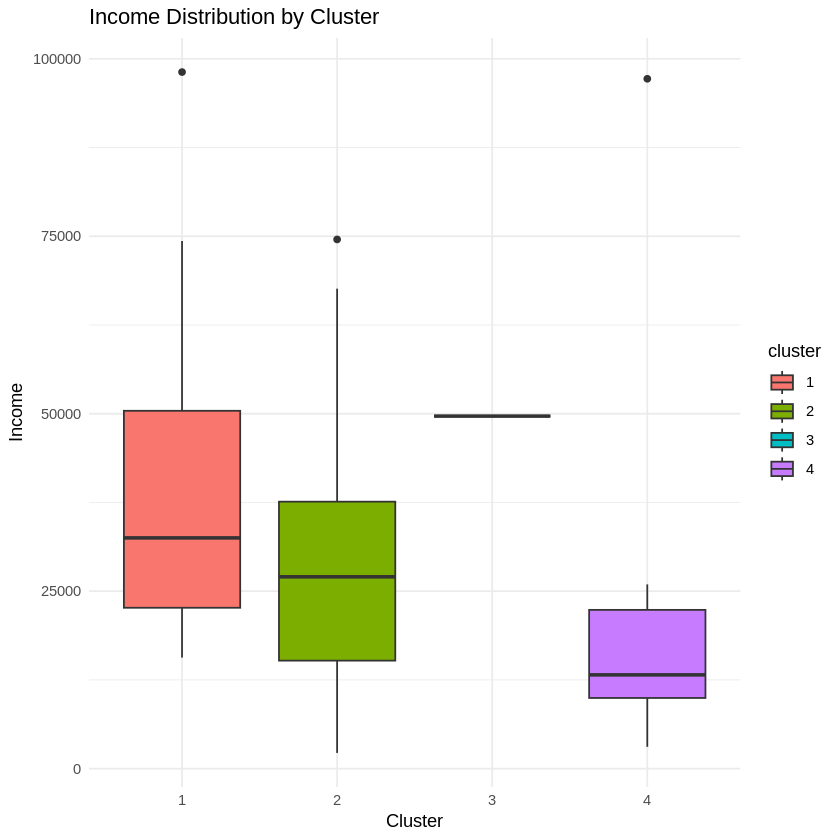

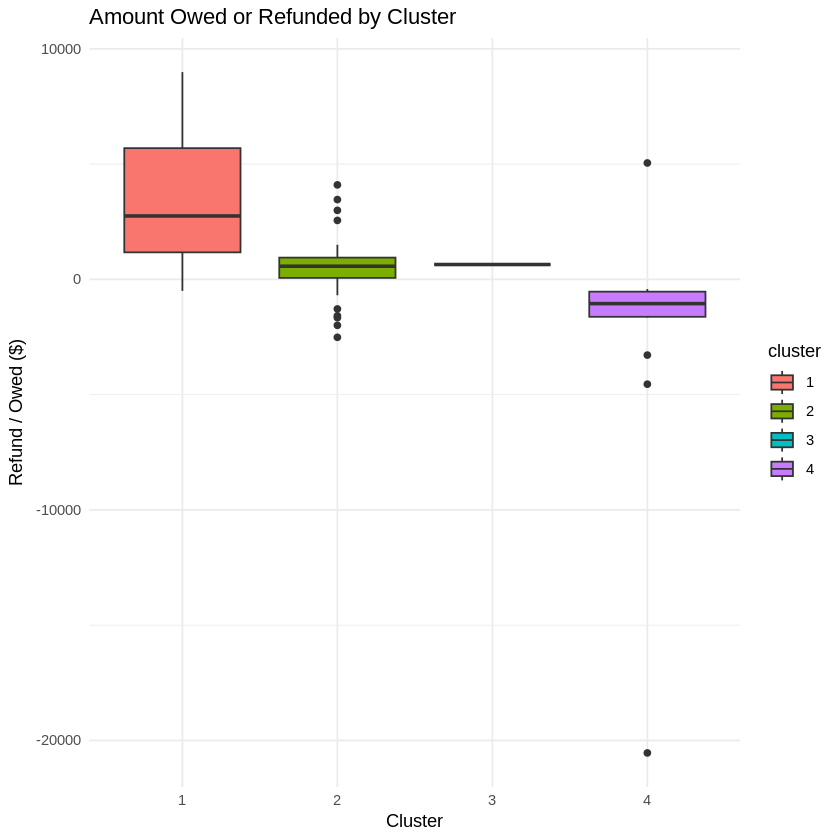

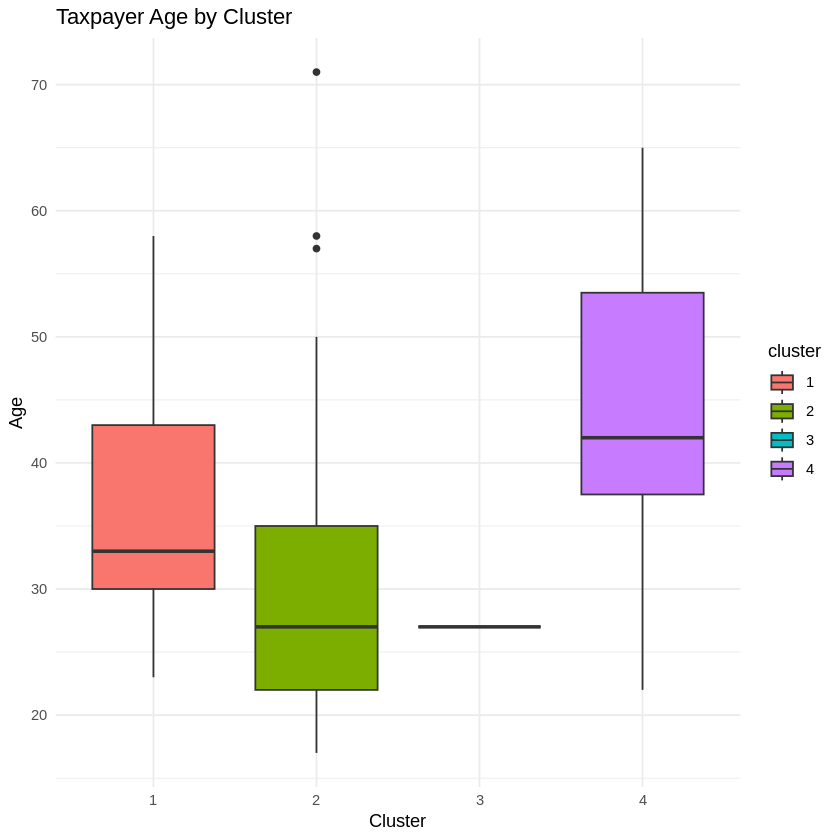

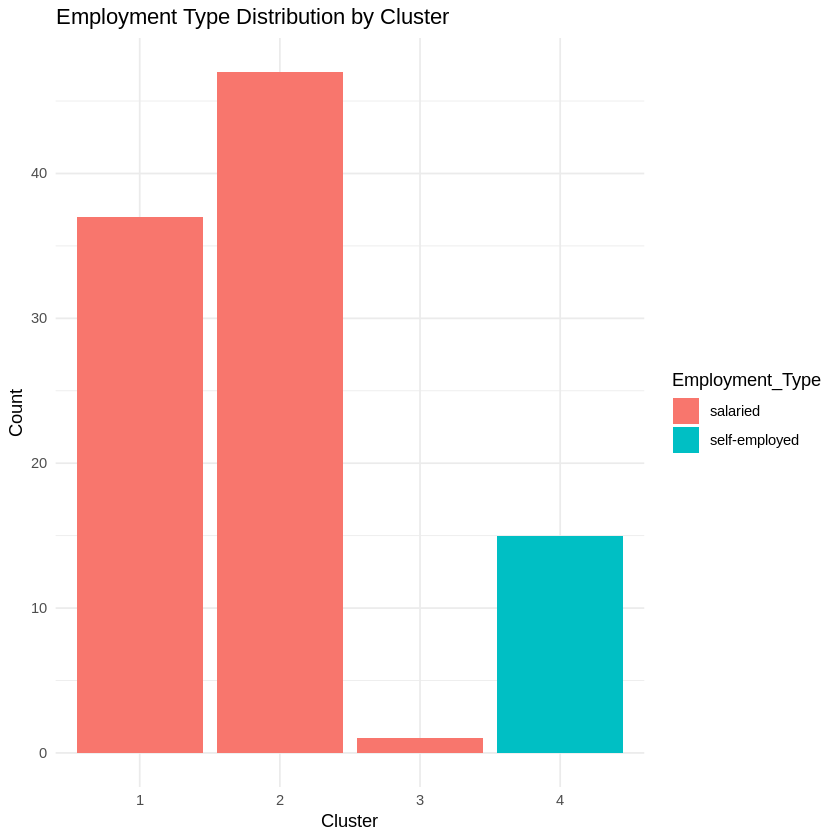

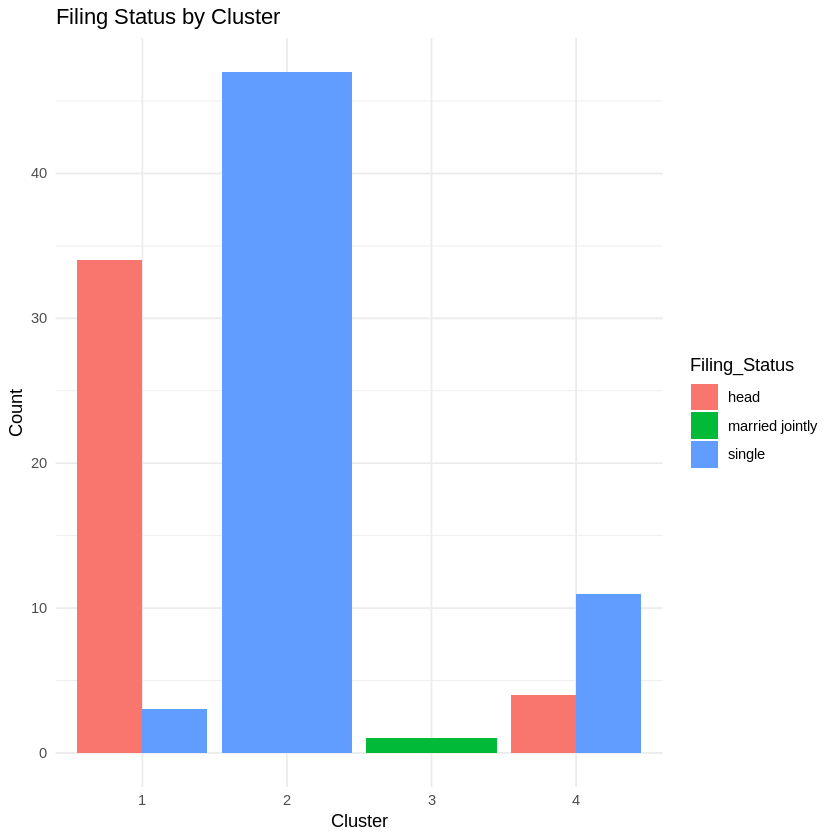

In [ ]:
# visualizations of how taxpayer characteristics vary across clusters

ggplot(df_cluster, aes(x = cluster, y = Income, fill = cluster)) +
  geom_boxplot() +
  theme_minimal() +
  labs(title = "Income Distribution by Cluster",
       x = "Cluster", y = "Income")

ggplot(df_cluster, aes(x = cluster, y = Amount_owed_or_Refund, fill = cluster)) +
  geom_boxplot() +
  theme_minimal() +
  labs(title = "Amount Owed or Refunded by Cluster",
       x = "Cluster", y = "Refund / Owed ($)")

ggplot(df_cluster, aes(x = cluster, y = Taxpayer_Age, fill = cluster)) +
  geom_boxplot() +
  theme_minimal() +
  labs(title = "Taxpayer Age by Cluster",
       x = "Cluster", y = "Age")

ggplot(df_cluster, aes(x = cluster, fill = Employment_Type)) +
  geom_bar(position = "dodge") +
  theme_minimal() +
  labs(title = "Employment Type Distribution by Cluster",
       x = "Cluster", y = "Count")

ggplot(df_cluster, aes(x = cluster, fill = Filing_Status)) +
  geom_bar(position = "dodge") +
  theme_minimal() +
  labs(title = "Filing Status by Cluster",
       x = "Cluster", y = "Count")



# A tibble: 3 × 7
  dbscan_cluster count avg_income avg_refund avg_age avg_dependents
  <fct>          <int>      <dbl>      <dbl>   <dbl>          <dbl>
1 1                 46     26992.       892.    29.9         0.217 
2 2                 11     12559.     -1567.    46.4         0.0909
3 3                 32     36378.      3399.    36.2         1.75  
# ℹ 1 more variable: avg_investment <dbl>


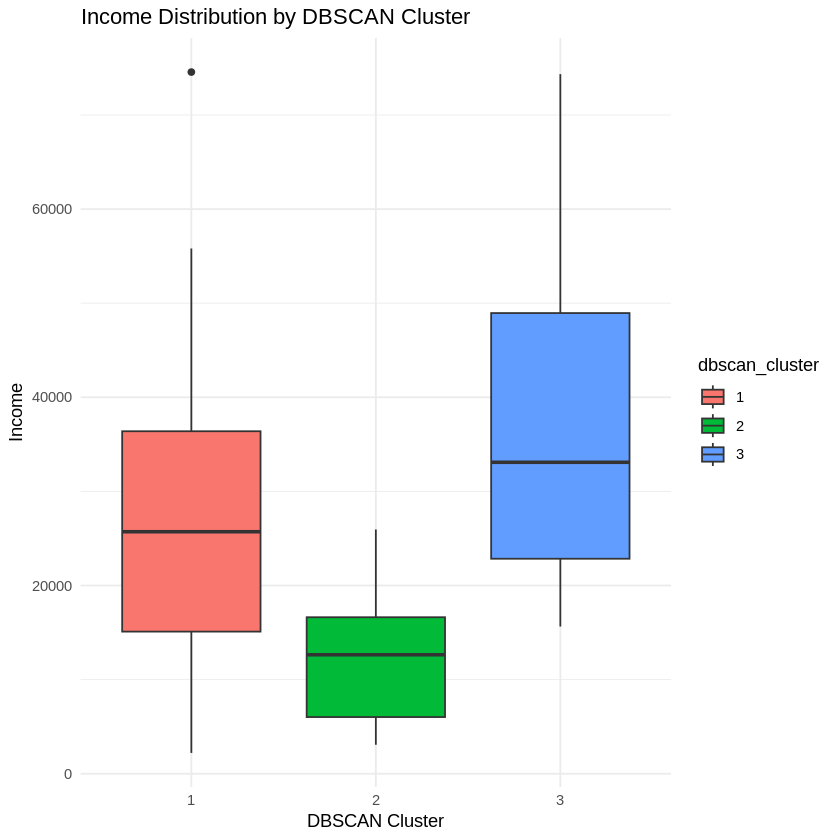

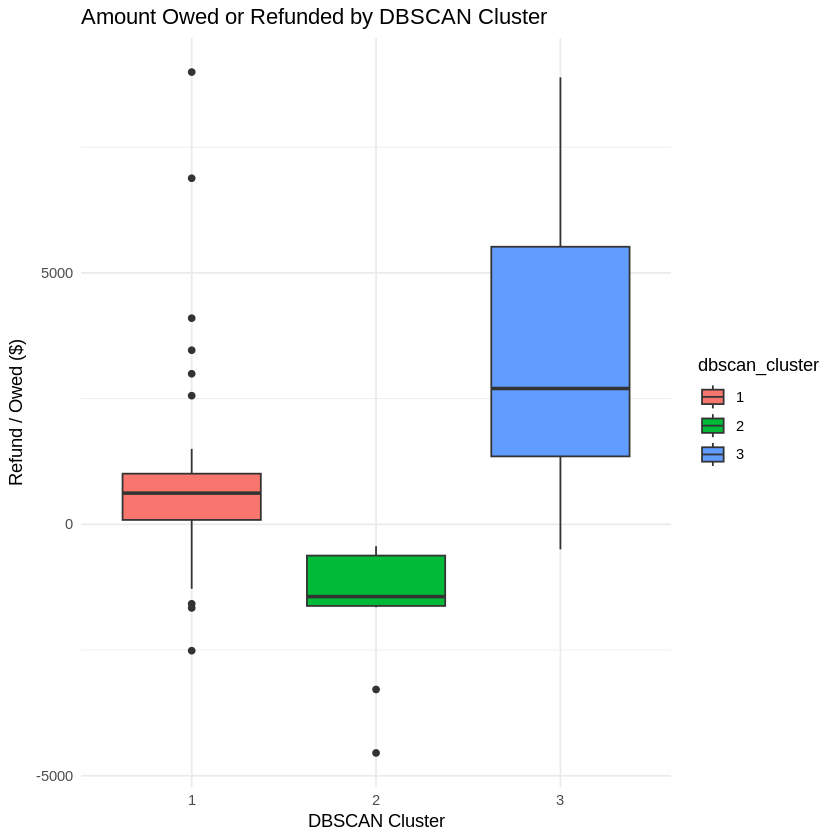

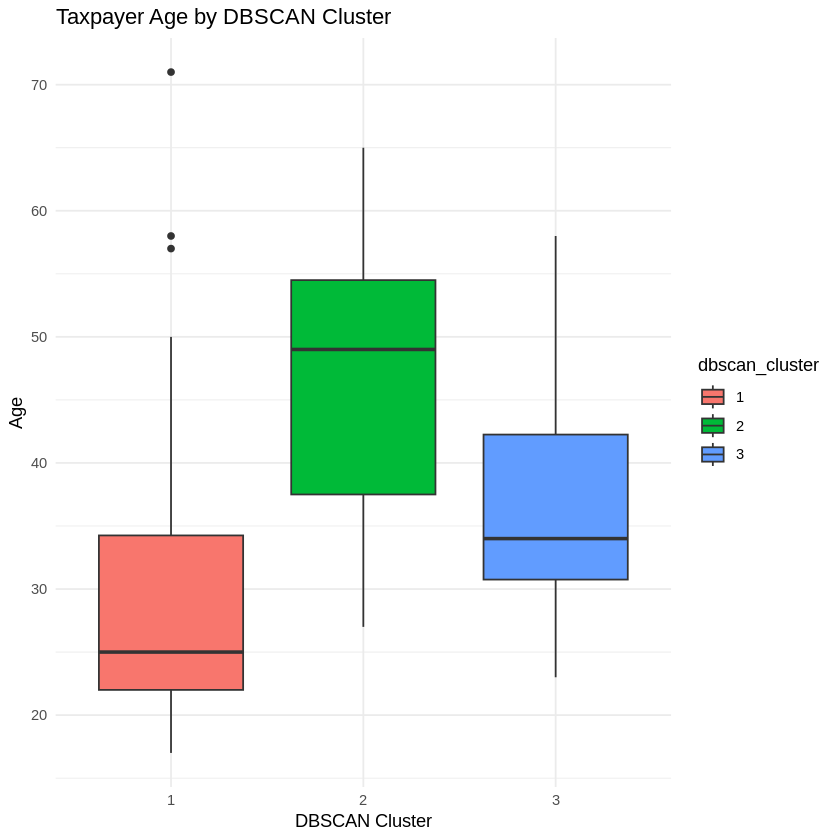

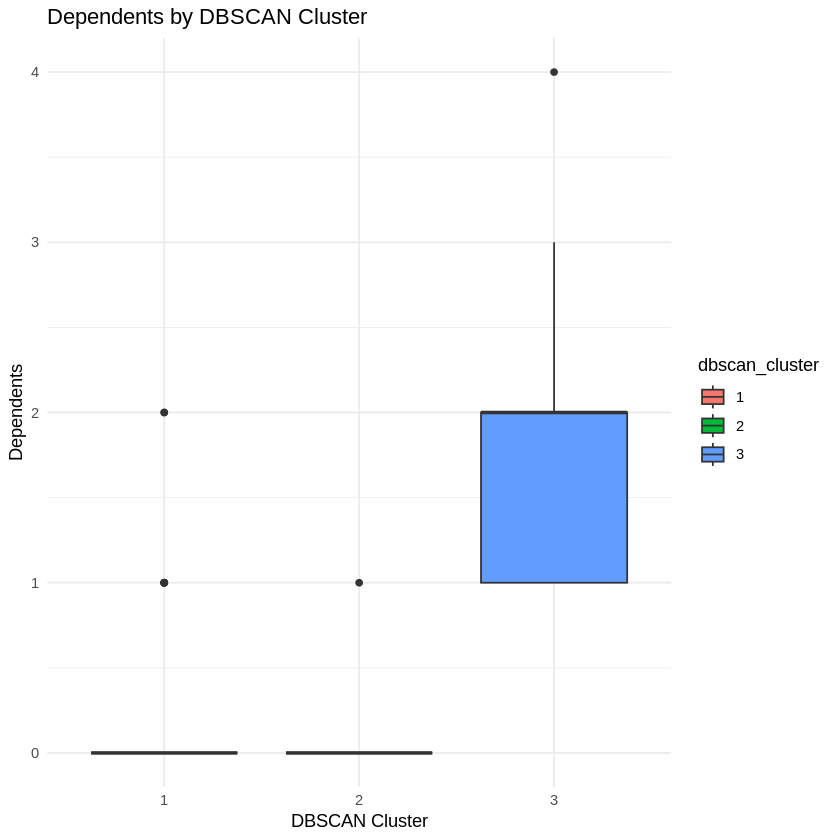

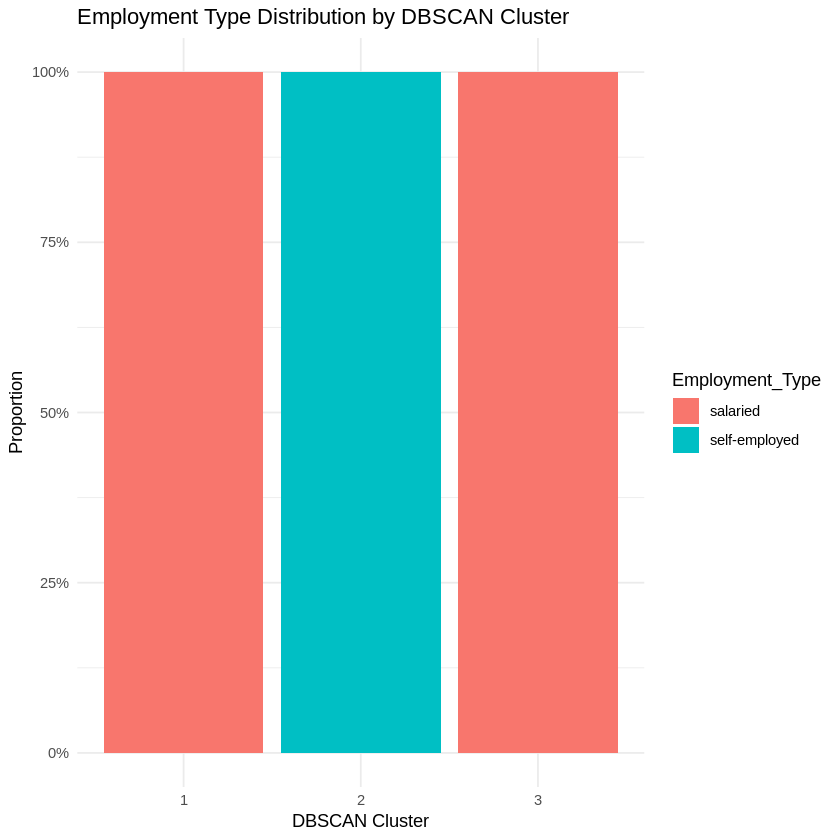

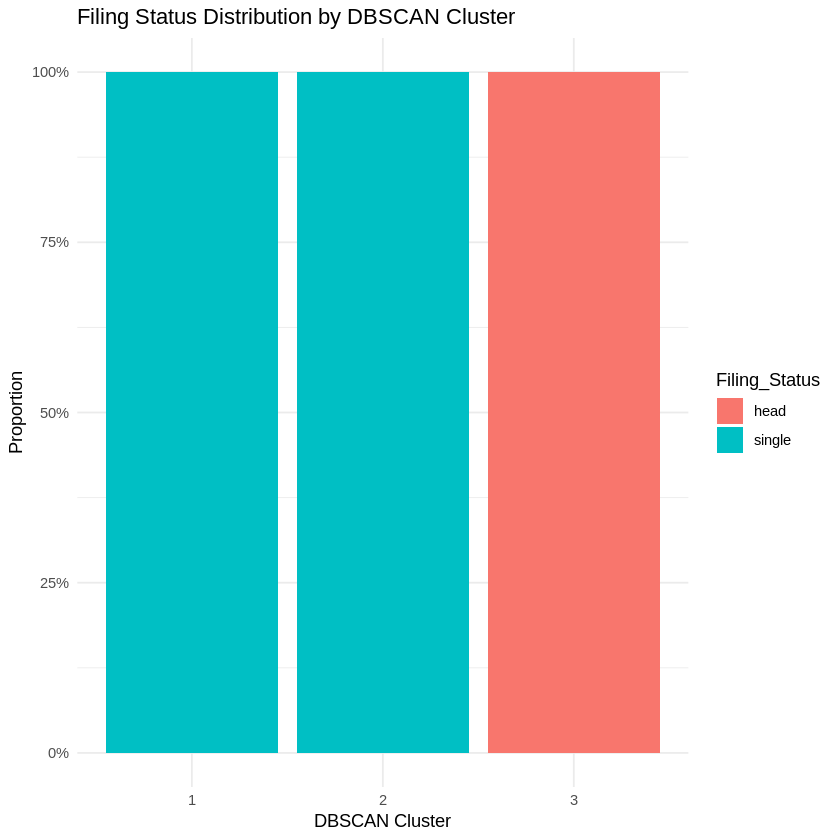

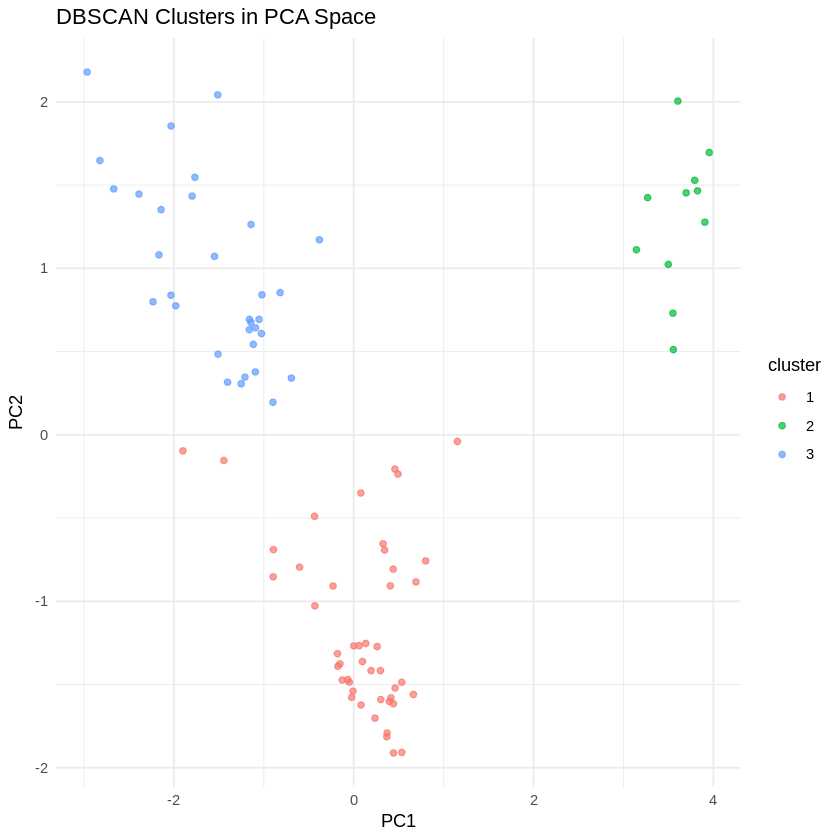

In [ ]:

df_cluster$dbscan_cluster <- as.factor(db_model$cluster)


df_profile <- df_cluster %>%
  filter(dbscan_cluster != 0)


summary_table <- df_profile %>%
  group_by(dbscan_cluster) %>%
  summarise(
    count = n(),
    avg_income = mean(Income, na.rm = TRUE),
    avg_refund = mean(Amount_owed_or_Refund, na.rm = TRUE),
    avg_age = mean(Taxpayer_Age, na.rm = TRUE),
    avg_dependents = mean(Dependents, na.rm = TRUE),
    avg_investment = mean(Investment_Income, na.rm = TRUE),
    .groups = "drop"
  )


print(summary_table)

library(ggplot2)

# Boxplot: Income
ggplot(df_profile, aes(x = dbscan_cluster, y = Income, fill = dbscan_cluster)) +
  geom_boxplot() +
  theme_minimal() +
  labs(title = "Income Distribution by DBSCAN Cluster",
       x = "DBSCAN Cluster", y = "Income")

# Boxplot: Refund/Owed
ggplot(df_profile, aes(x = dbscan_cluster, y = Amount_owed_or_Refund, fill = dbscan_cluster)) +
  geom_boxplot() +
  theme_minimal() +
  labs(title = "Amount Owed or Refunded by DBSCAN Cluster",
       x = "DBSCAN Cluster", y = "Refund / Owed ($)")

# Boxplot: Age
ggplot(df_profile, aes(x = dbscan_cluster, y = Taxpayer_Age, fill = dbscan_cluster)) +
  geom_boxplot() +
  theme_minimal() +
  labs(title = "Taxpayer Age by DBSCAN Cluster",
       x = "DBSCAN Cluster", y = "Age")

# Boxplot: Dependents
ggplot(df_profile, aes(x = dbscan_cluster, y = Dependents, fill = dbscan_cluster)) +
  geom_boxplot() +
  theme_minimal() +
  labs(title = "Dependents by DBSCAN Cluster",
       x = "DBSCAN Cluster", y = "Dependents")

# Employment Type Distribution
ggplot(df_profile, aes(x = dbscan_cluster, fill = Employment_Type)) +
  geom_bar(position = "fill") +
  scale_y_continuous(labels = scales::percent_format()) +
  theme_minimal() +
  labs(title = "Employment Type Distribution by DBSCAN Cluster",
       x = "DBSCAN Cluster", y = "Proportion")

# Filing Status Distribution
ggplot(df_profile, aes(x = dbscan_cluster, fill = Filing_Status)) +
  geom_bar(position = "fill") +
  scale_y_continuous(labels = scales::percent_format()) +
  theme_minimal() +
  labs(title = "Filing Status Distribution by DBSCAN Cluster",
       x = "DBSCAN Cluster", y = "Proportion")

# PCA projection with DBSCAN clusters
pca <- prcomp(df_scaled)
pca_df <- as.data.frame(pca$x[, 1:2]) %>%
  mutate(cluster = as.factor(db_labels))

ggplot(pca_df[valid, ], aes(x = PC1, y = PC2, color = cluster)) +
  geom_point(alpha = 0.7) +
  theme_minimal() +
  labs(title = "DBSCAN Clusters in PCA Space")
